In [1]:
import librosa
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, f1_score
import soundfile as sf
import seaborn as sns
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset

from pytube import YouTube
from pydub import AudioSegment
from pytube.innertube import InnerTube
import subprocess

SR = 16000 # Sufficient to perceive the frequency range of human voices
HOP_LENGTH = 512
NFFT = 2048

# DATA COLLECTION 
To collect quality data for each language, videos with a "Creative Commons" license were watched on YouTube. The URLs of the videos, which totaled approximately 6 hours, were saved in csv files. Data Collection codes were written to download these URLs as wav files and create 13-second segments. This data will be combined with OpenSLR data and converted to a spectrogram and then used in model training.

In [23]:
def youtube_to_wav(youtube_url, output_path="output.wav"):
    command = [
        "yt-dlp",
        "--extract-audio",
        "--audio-format", "wav",
        "--audio-quality", "0",  # Highest quality (0 is best)
        "--output", output_path,
        youtube_url,
    ]
    
    try:
        subprocess.run(command, check=True, capture_output=True, text=True)
    except subprocess.CalledProcessError as e:
        print(f"Error occurred: {e.stderr}")
        print(f"Command output: {e.stdout}")

In [24]:
# Saves wav files to respective directory and adds "filename" column to dataframe
def save_data(df, out_dir):
    i = 0
    filenames = []
    for url in df['url']:
        filename = f"{i}.wav"
        out_path = out_dir + f"/{filename}"

        youtube_to_wav(url, output_path=out_path)

        filenames.append(filename)
        
        i+=1

    filenames = pd.Series(filenames)
    df["filename"] = filenames

    return df

## Read csv files and download the wav files from urls

In [25]:
df_tr = pd.read_csv("../urls/tr.csv")
df_tr.head()

start    end                                          url
0   0.10   7.57  https://www.youtube.com/watch?v=ihrIL2qQbgs
1   0.00  17.22  https://www.youtube.com/watch?v=GAz-K_iFfM8
2   0.13    NaN  https://www.youtube.com/watch?v=Nm3g8PokIp0
3   0.03   1.55  https://www.youtube.com/watch?v=N5I5NDkNPRc
4   0.03   1.00  https://www.youtube.com/watch?v=SsvdgkeNePw

In [26]:
df_tr = save_data(df_tr, "../data/collected/tr_new")
df_tr.head()

start    end                                          url filename
0   0.10   7.57  https://www.youtube.com/watch?v=ihrIL2qQbgs    0.wav
1   0.00  17.22  https://www.youtube.com/watch?v=GAz-K_iFfM8    1.wav
2   0.13    NaN  https://www.youtube.com/watch?v=Nm3g8PokIp0    2.wav
3   0.03   1.55  https://www.youtube.com/watch?v=N5I5NDkNPRc    3.wav
4   0.03   1.00  https://www.youtube.com/watch?v=SsvdgkeNePw    4.wav

In [27]:
df_es = pd.read_csv("../urls/es.csv")
df_es.head()

start    end                                          url
0   0.05   3.30  https://www.youtube.com/watch?v=GoUOny9HoSE
1   0.05   3.35  https://www.youtube.com/watch?v=bCtFIM80oJE
2   0.07  21.52  https://www.youtube.com/watch?v=cytY3YH1f2I
3   0.10  16.25  https://www.youtube.com/watch?v=MrPEnikb2Rk
4   0.02   2.48  https://www.youtube.com/watch?v=7KAan82-uEk

In [28]:
df_es = save_data(df_es, "../data/collected/es_new")
df_es.head()

start    end                                          url filename
0   0.05   3.30  https://www.youtube.com/watch?v=GoUOny9HoSE    0.wav
1   0.05   3.35  https://www.youtube.com/watch?v=bCtFIM80oJE    1.wav
2   0.07  21.52  https://www.youtube.com/watch?v=cytY3YH1f2I    2.wav
3   0.10  16.25  https://www.youtube.com/watch?v=MrPEnikb2Rk    3.wav
4   0.02   2.48  https://www.youtube.com/watch?v=7KAan82-uEk    4.wav

In [29]:
df_fr = pd.read_csv("../urls/fr.csv")
df_fr.head()

start    end                                          url
0   0.06   3.20  https://www.youtube.com/watch?v=QwnADXL9yk8
1   0.00   0.45  https://www.youtube.com/watch?v=PO5vtZMw7SY
2   0.05  10.15  https://www.youtube.com/watch?v=HhljUdMUbs0
3   0.16   4.00  https://www.youtube.com/watch?v=qxmX6Jp5Mk0
4   0.10   2.44  https://www.youtube.com/watch?v=ga-j8zSAXH4

In [30]:
df_fr = save_data(df_fr, "../data/collected/fr_new")
df_fr.head()

start    end                                          url filename
0   0.06   3.20  https://www.youtube.com/watch?v=QwnADXL9yk8    0.wav
1   0.00   0.45  https://www.youtube.com/watch?v=PO5vtZMw7SY    1.wav
2   0.05  10.15  https://www.youtube.com/watch?v=HhljUdMUbs0    2.wav
3   0.16   4.00  https://www.youtube.com/watch?v=qxmX6Jp5Mk0    3.wav
4   0.10   2.44  https://www.youtube.com/watch?v=ga-j8zSAXH4    4.wav

In [31]:
df_ar = pd.read_csv("../urls/ar.csv")
df_ar.head()

start   end                                          url
0   0.00  7.03  https://www.youtube.com/watch?v=ckcbx_BeJtY
1   0.00  5.59  https://www.youtube.com/watch?v=2L-Szfp4hxI
2   0.00  1.05  https://www.youtube.com/watch?v=ISC14UkFA6E
3   0.05  5.55  https://www.youtube.com/watch?v=XDxVS-WgFsE
4   0.06  3.01  https://www.youtube.com/watch?v=3seRFWdXe0o

In [32]:
df_ar = save_data(df_ar, "../data/collected/ar_new")
df_ar.head()

start   end                                          url filename
0   0.00  7.03  https://www.youtube.com/watch?v=ckcbx_BeJtY    0.wav
1   0.00  5.59  https://www.youtube.com/watch?v=2L-Szfp4hxI    1.wav
2   0.00  1.05  https://www.youtube.com/watch?v=ISC14UkFA6E    2.wav
3   0.05  5.55  https://www.youtube.com/watch?v=XDxVS-WgFsE    3.wav
4   0.06  3.01  https://www.youtube.com/watch?v=3seRFWdXe0o    4.wav

In [33]:
# To convert minutes to seconds when clipping audio
def min_to_sec(value):
    if pd.isna(value):
        return pd.NA
    
    minutes = int(value)
    seconds = value - minutes
    total_seconds = minutes * 60 + seconds

    return int(total_seconds)

## Clip only the talking parts of audios

In [34]:
def clip_wav(df, data_dir):
    clips = []
    for index,row in df.iterrows():
        path = data_dir + f"/{row['filename']}"
        
        start = row["start"] # e.g. 0.05 (needs to be converted to seconds)
        end = row["end"] # e.g. 2.35 (needs to be converted to seconds)

        start = min_to_sec(start)
        end = min_to_sec(end)

        y, sr = librosa.load(path, sr=SR)
    
        start*= sr
        end*= sr

        if pd.isna(end):
            clip = y[start:]
        else:
            clip = y[start:end]
        
        clips.append(clip)

    return clips 

In [35]:
ar_list = clip_wav(df_ar, "../data/collected/ar_new")
es_list = clip_wav(df_es, "../data/collected/es_new")
fr_list = clip_wav(df_fr, "../data/collected/fr_new")
tr_list = clip_wav(df_tr, "../data/collected/tr_new")

In [36]:
def spec_show(y, sr, title):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=HOP_LENGTH, n_fft=NFFT)

    plt.figure(figsize=(10, 4))

    db_spec = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    print(db_spec.shape)
    librosa.display.specshow(db_spec, sr=sr, x_axis='time', y_axis='mel')

    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-Spektrogram - {title}')
    plt.tight_layout()
    plt.show()

# Sample Spectrograms (Collected Data)

(128, 13126)


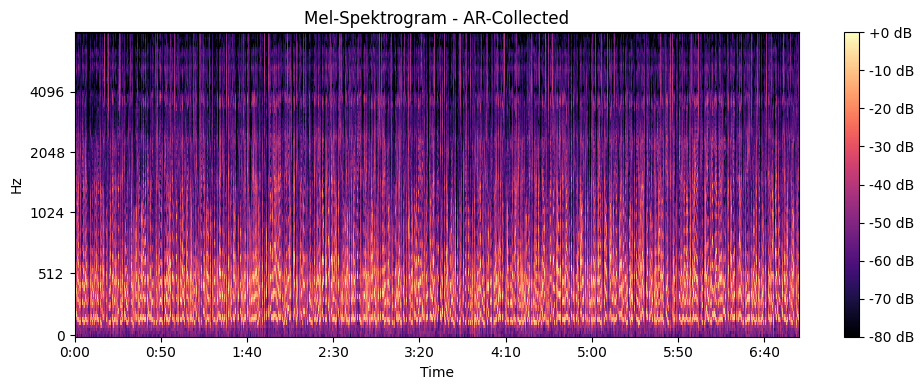

(128, 5626)


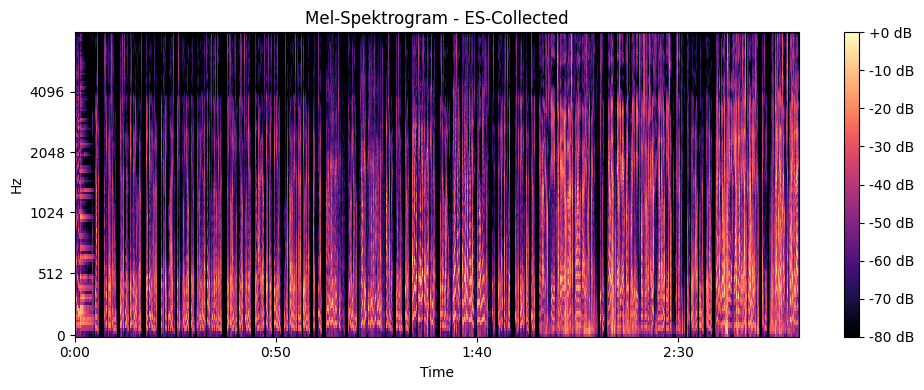

(128, 5626)


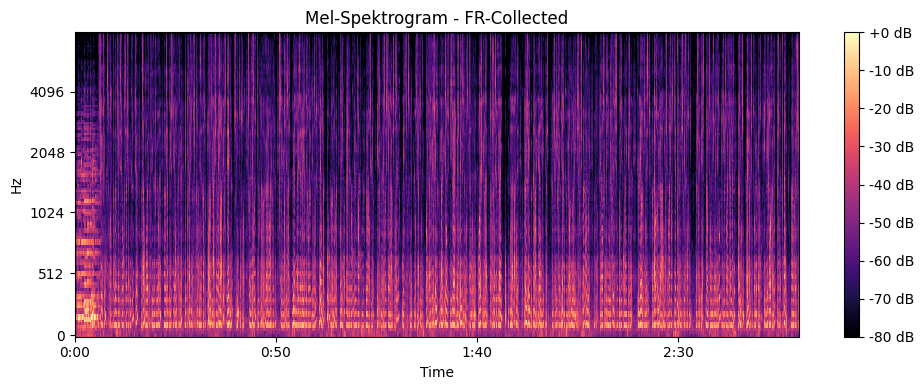

(128, 13126)


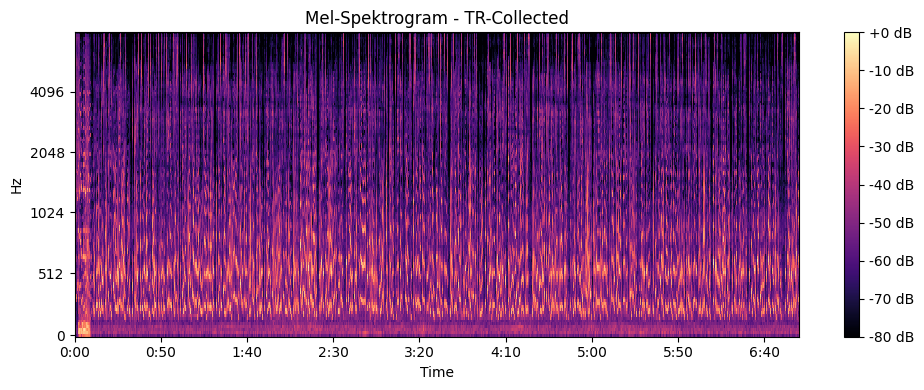

In [177]:
spec_show(ar_list[0], SR, "AR-Collected")
spec_show(es_list[0], SR, "ES-Collected")
spec_show(fr_list[0], SR, "FR-Collected")
spec_show(tr_list[0], SR, "TR-Collected")

## Split data into 13-second segments

In [37]:
def segment_data(array_list, label, duration=13):
    segmented_list = [] 
    labels = []

    for array in array_list:
        array_length = len(array)
        start = 0
        end = SR * duration
        
        while array_length - end >= 13*SR:
            segment = array[start:end]
            segmented_list.append(segment)
            labels.append(label)

            start += 13*SR
            end += 13*SR
    
    segmented_arr = np.array(segmented_list)
    labels_arr = np.array(labels)

    return segmented_arr, labels_arr

In [38]:
ar_segmented, ar_labels = segment_data(ar_list, 0)
es_segmented, es_labels = segment_data(es_list, 1)
fr_segmented, fr_labels = segment_data(fr_list, 2)
tr_segmented, tr_labels = segment_data(tr_list, 3)

In [39]:
ar_segmented.shape, es_segmented.shape, fr_segmented.shape, tr_segmented.shape

((329, 208000), (321, 208000), (322, 208000), (336, 208000))

**Number of collected datapoints(13 seconds) per class**\
Arabic: 329  -  Spanish: 321  -  French: 322  -  Turkish: 336 || Total: 1308

## Sample 13-second spectrograms 

(128, 407)


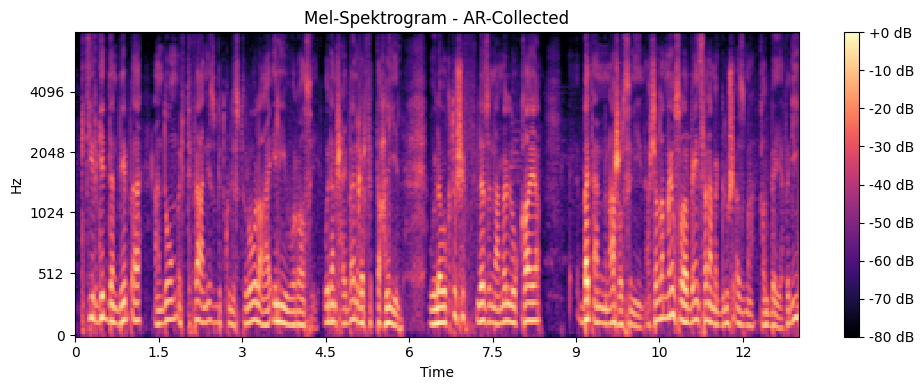

(128, 407)


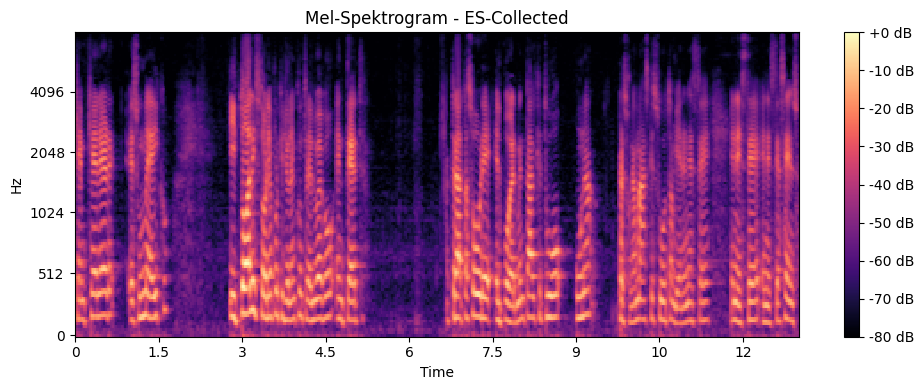

(128, 407)


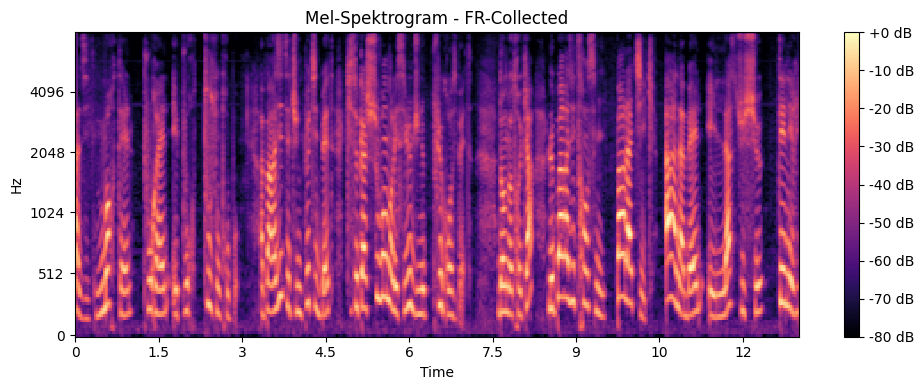

(128, 407)


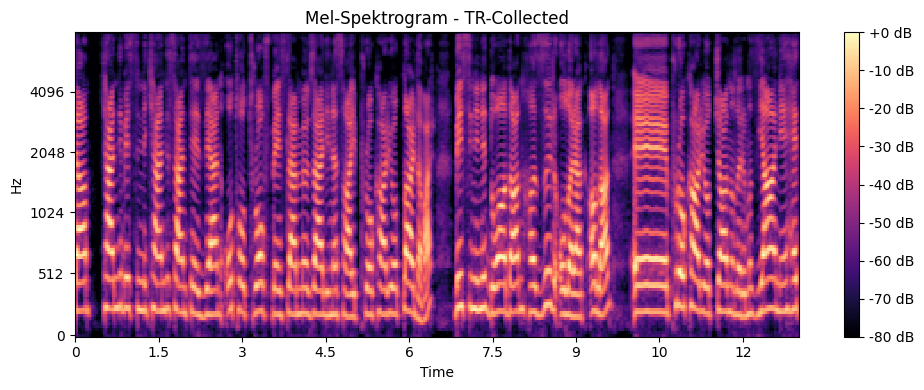

In [178]:
spec_show(ar_segmented[100], SR, "AR-Collected")
spec_show(es_segmented[100], SR, "ES-Collected")
spec_show(fr_segmented[100], SR, "FR-Collected")
spec_show(tr_segmented[100], SR, "TR-Collected")

# OPENSLR DATASET
https://www.openslr.org/108/

In [40]:
DATA_DIR = "../data/openslr"
AR_DIR = DATA_DIR + "/AR"
ES_DIR = DATA_DIR + "/ES"
FR_DIR = DATA_DIR + "/FR"
TR_DIR = DATA_DIR + "/TR"

In [41]:
filename_AR = "/0a0d1abd-0bd3-45f8-818f-8ab214be329e.flac"
filename_ES = "/0a530b75-d3b1-4533-8ca9-f405d41b445e.flac"
filename_FR = "/00c2529e-9705-464e-bbc2-acbe19916095.flac"
filename_TR = "/00a38ecc-2a37-4c3f-803b-607031004e4f.flac"

file_path_AR = AR_DIR + filename_AR
file_path_ES = ES_DIR + filename_ES
file_path_FR = FR_DIR + filename_FR
file_path_TR = TR_DIR + filename_TR

In [42]:
# def mel_to_audio(db_spec, sr):
#     # Mel-spektrogramı geri mel amplitüdüne çevir
#     S = librosa.db_to_power(db_spec)

#     y_inv = librosa.feature.inverse.mel_to_audio(S, sr=sr, hop_length=HOP_LENGTH, n_fft=NFFT)

#     sf.write('geri.wav', y_inv, sr)
#     return y_inv

# Sample Spectrograms (OpenSLR Data)

AR
(128, 466)


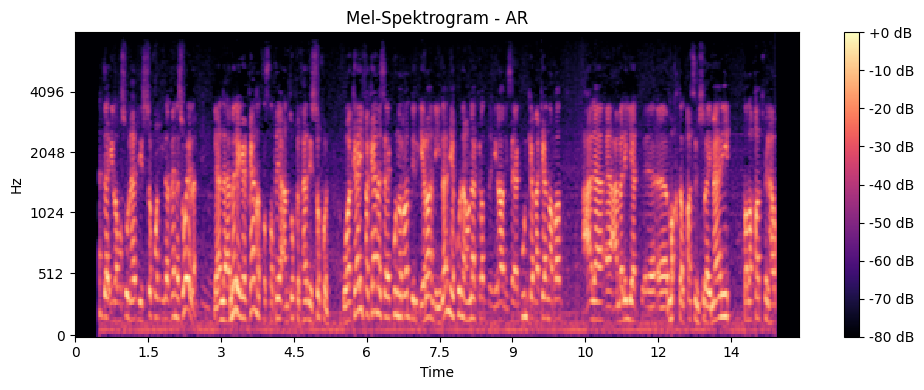

(128, 451)


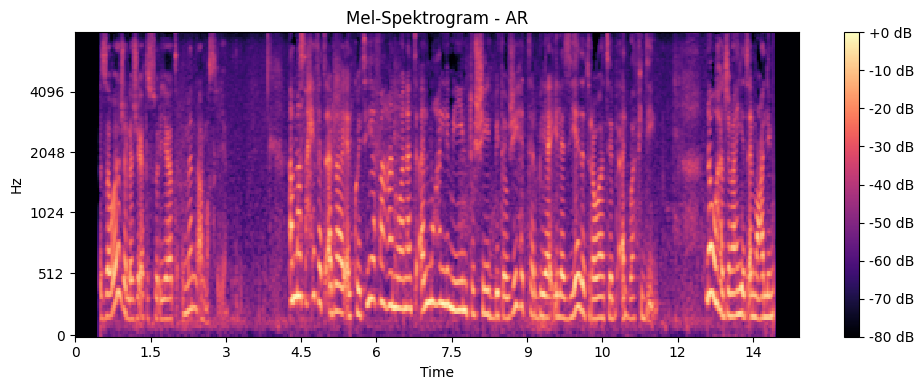

(128, 419)


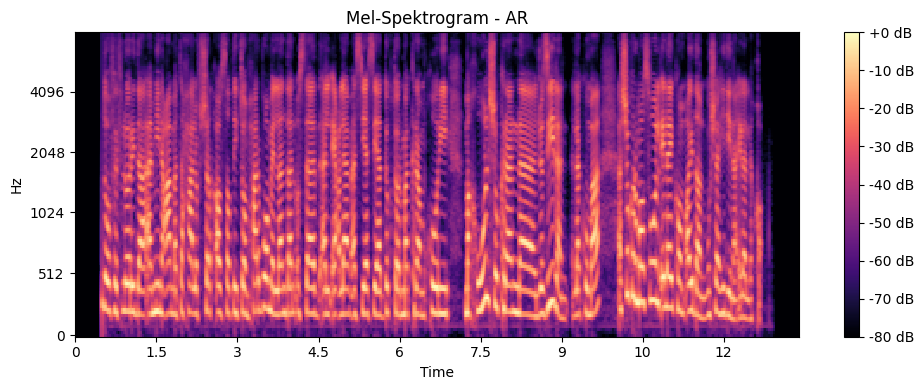

ES
(128, 466)


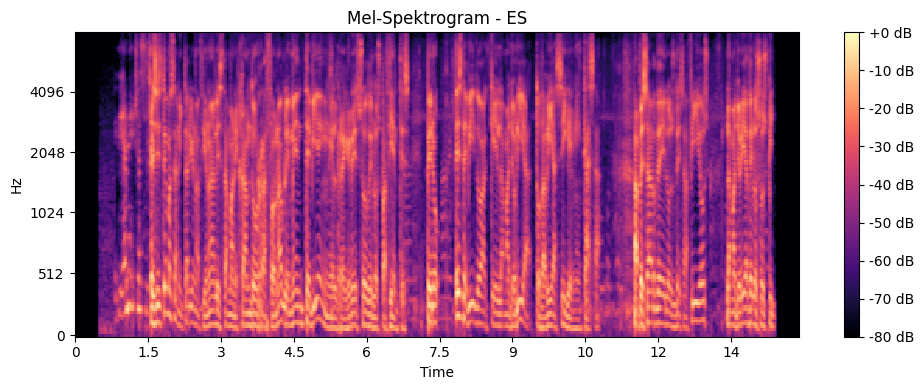

(128, 460)


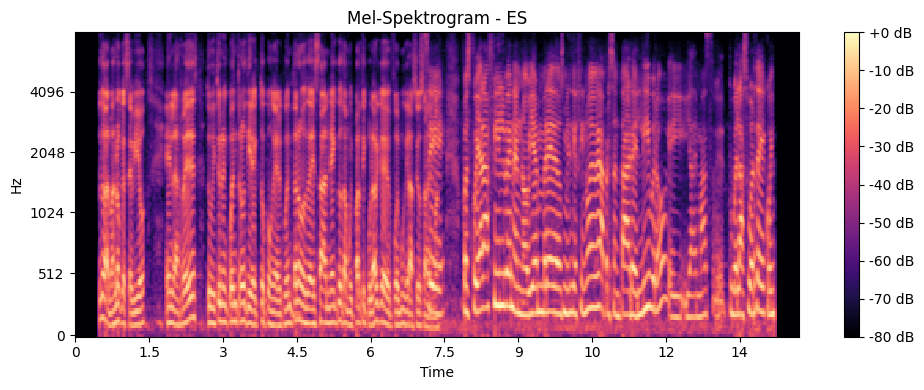

(128, 229)


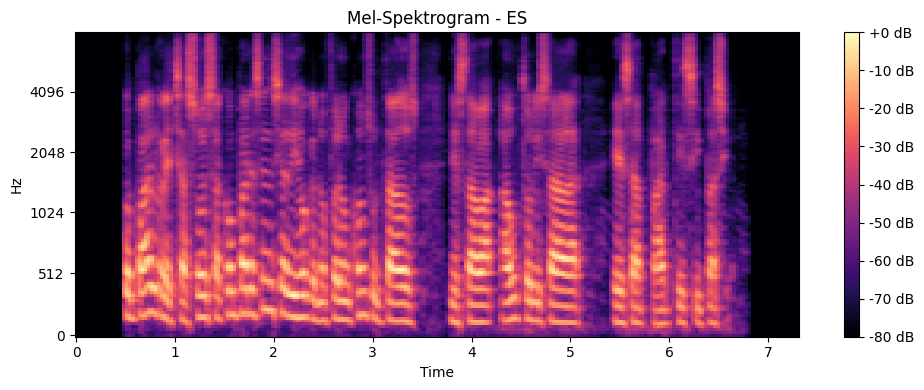

FR
(128, 463)


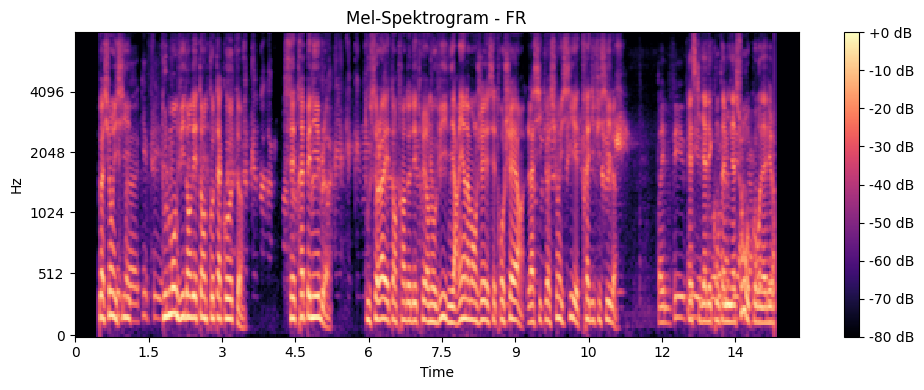

(128, 413)


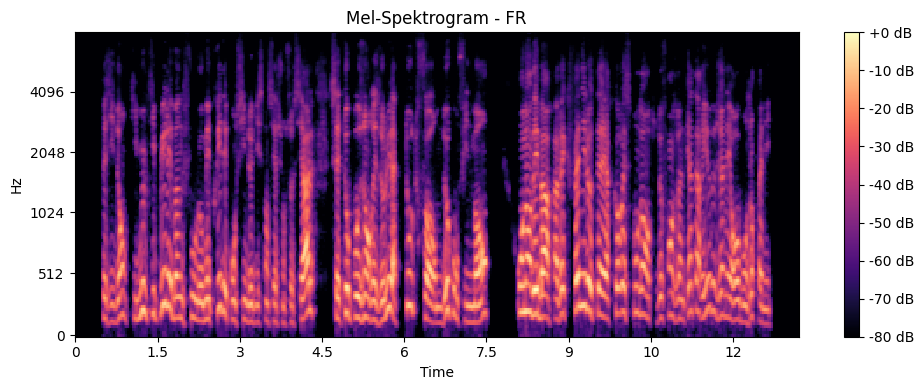

(128, 451)


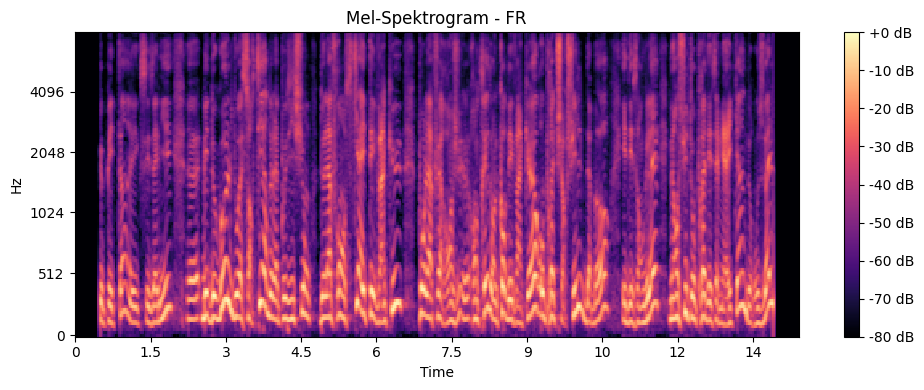

TR
(128, 454)


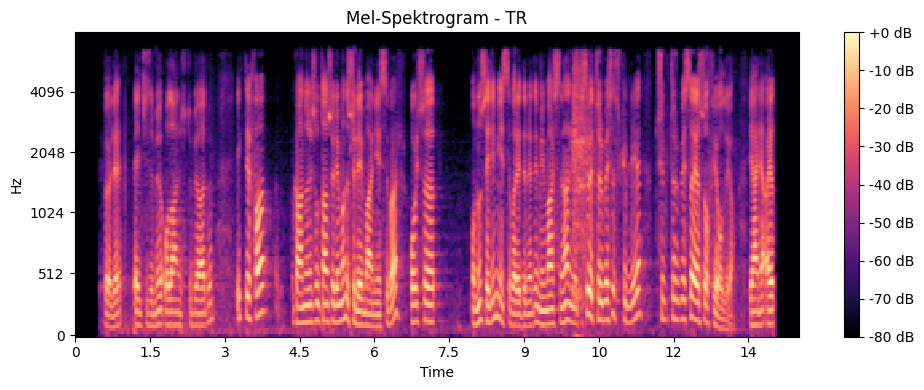

(128, 457)


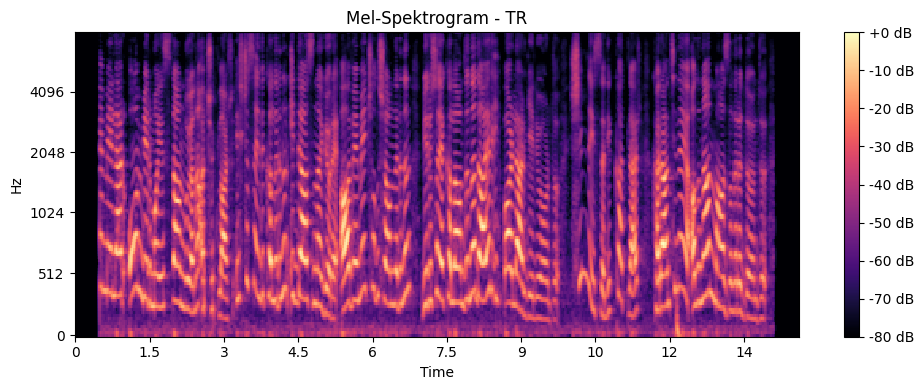

(128, 463)


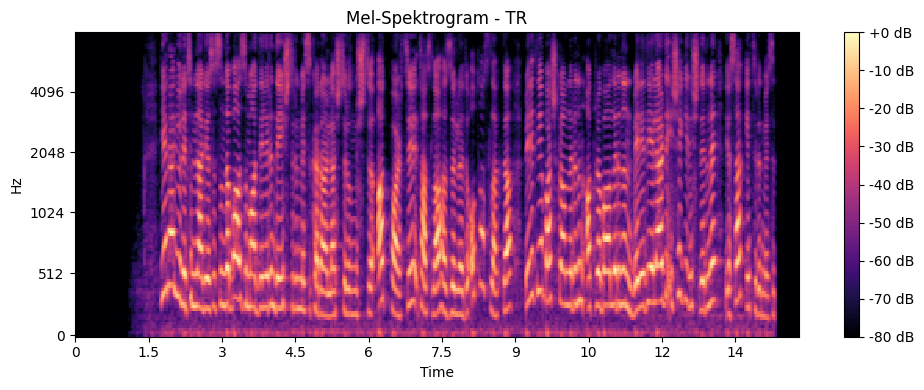

Minimum Length (seconds): 3.4
Maximum Length (seconds): 14.9
Total files shorter than 13 seconds: 572
Total files: 10022


In [21]:
min_len = np.inf
max_len = 0
short_files = 0
total_files = 0
for folder_name in os.listdir(DATA_DIR):
    print(folder_name)
    folder_path = os.path.join(DATA_DIR, folder_name)
    i = 0
    for filename in os.listdir(folder_path):
    
        if filename.endswith("txt"):
            continue
        
        total_files += 1

        path = os.path.join(folder_path, filename)
        y, sr = librosa.load(path, sr=None)

        if len(y) < min_len:
            min_len = len(y)
        
        if len(y) > max_len:
            max_len = len(y)

        if len(y) / sr < 13:
            short_files += 1

        if i < 3:
            spec_show(y,sr,folder_name)
        
        i+=1

print("Minimum Length (seconds):", min_len / 16000)
print("Maximum Length (seconds):", max_len / 16000)
print("Total files shorter than 13 seconds:", short_files)
print("Total files:", total_files)
        

**Not all audio files are the same length. In order to feed them to the CNN model, the spectrograms need to be of equal shape. We can ignore the very short sounds and apply padding to bring the sizes of the slightly short ones to the target size. Also, there are completely silent columns at the beginning and end of the sample spectrograms, these will need to be addressed as well.**

### Trim the silent parts that appear at the beginning and end of the audios. Then, cut the 13-second parts and save them to array.

In [43]:
def trim_silence(waveform, threshold=1e-4):
    start_index = np.argmax(np.abs(waveform) > threshold)
    end_index = len(waveform) - np.argmax(np.abs(waveform[::-1]) > threshold) - 1
    
    trimmed_waveform = waveform[start_index:end_index+1]
    
    return trimmed_waveform

In [44]:
x_list = []
y_list = []

label = -1
for folder_name in os.listdir(DATA_DIR):
    label += 1
    folder_path = os.path.join(DATA_DIR, folder_name)
    for filename in os.listdir(folder_path):

        if filename.endswith("txt"):
            continue
        
        path = os.path.join(folder_path, filename)
        y, sr = librosa.load(path, sr=SR)

        y = trim_silence(y)
        
        seconds = len(y) / SR
        if seconds < 13:
            continue

        y = y[:13*SR]

        x_list.append(y)
        y_list.append(label) 

print("Number of datapoints(13 seconds) from OpenSLR :", len(y_list))

x_array = np.array(x_list)
y_array = np.array(y_list)

bins = np.bincount(y_array)
print(f"Arabic: {bins[0]}  -  Spanish: {bins[1]}  -  French: {bins[2]}  -  Turkish: {bins[3]}")

Number of datapoints(13 seconds) from OpenSLR : 8760
Arabic: 2185  -  Spanish: 2173  -  French: 2224  -  Turkish: 2178


# Bring collected data and OpenSLR data together

In [45]:
X_wave = np.concatenate((ar_segmented, es_segmented, fr_segmented, tr_segmented, x_array), axis=0)
Y = np.concatenate((ar_labels, es_labels, fr_labels, tr_labels, y_array))

X_wave.shape, Y.shape

((10068, 208000), (10068,))

In [46]:
bins = np.bincount(Y)
print("Total datapoints(13 seconds) per class:")
print(f"Arabic: {bins[0]}  -  Spanish: {bins[1]}  -  French: {bins[2]}  -  Turkish: {bins[3]}  ||  Total: {np.sum(bins)}")

Total datapoints(13 seconds) per class:
Arabic: 2514  -  Spanish: 2494  -  French: 2546  -  Turkish: 2514  ||  Total: 10068


## Convert wave form audios to mel-spectrograms

In [47]:
def audio_to_spec(y, sr):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=512, n_fft=NFFT)
    db_spec = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return db_spec

In [48]:
X_spec_list = []

for signal in X_wave:
    spec = audio_to_spec(signal, SR)
    X_spec_list.append(spec)

X = (np.array(X_spec_list) + 80) / 80 # Normalize data to (0,1) range

## Split dataset

In [49]:
# Split Data
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, train_size=0.6, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp)

# X_train = torch.from_numpy(X_train).unsqueeze(1)
# X_val = torch.from_numpy(X_val).unsqueeze(1)
# X_test = torch.from_numpy(X_test).unsqueeze(1)

# Y_train = torch.from_numpy(Y_train)
# Y_val = torch.from_numpy(Y_val)
# Y_test = torch.from_numpy(Y_test)

np.save("X_train", X_train)
np.save("Y_train", Y_train)

np.save("X_val", X_val)
np.save("Y_val", Y_val)

np.save("X_test", X_test)
np.save("Y_test", Y_test)

In [50]:
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_val, return_counts=True))
print(np.unique(Y_test, return_counts=True))

(array([0, 1, 2, 3]), array([1508, 1496, 1528, 1508]))
(array([0, 1, 2, 3]), array([503, 499, 509, 503]))
(array([0, 1, 2, 3]), array([503, 499, 509, 503]))


# Create Torch Dataset

In [2]:
class CustomDataset(Dataset):
    def __init__(self, X_data, Y_data):
        self.X = torch.from_numpy(X_data).unsqueeze(1)
        self.Y = torch.from_numpy(Y_data)
        print("Shape:", self.X.shape)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sample = self.X[idx], self.Y[idx]
        return sample

In [106]:
train_dataset = CustomDataset(X_train, Y_train)
val_dataset = CustomDataset(X_val, Y_val)
test_dataset = CustomDataset(X_test, Y_test)
all_data = CustomDataset(X, Y)

Shape: torch.Size([6040, 1, 128, 407])
Shape: torch.Size([2014, 1, 128, 407])
Shape: torch.Size([2014, 1, 128, 407])
Shape: torch.Size([10068, 1, 128, 407])


In [165]:
torch.save(train_dataset, "train_dataset.pth")
torch.save(val_dataset, "val_dataset.pth")
torch.save(test_dataset, "test_dataset.pth")
torch.save(all_data, "all_dataset.pth")

In [51]:
train_dataset = torch.load("train_dataset.pth")
val_dataset = torch.load("val_dataset.pth")
test_dataset = torch.load("test_dataset.pth")
all_data = torch.load("all_dataset.pth")

X_train = np.load("X_train.npy")
Y_train = np.load("Y_train.npy")

X_val = np.load("X_val.npy")
Y_val = np.load("Y_val.npy")

X_test = np.load("X_test.npy")
Y_test = np.load("Y_test.npy")

C:\Users\osati\AppData\Local\Temp\ipykernel_18304\1209720407.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load("train_dataset.pth")
C:\Users\osa

# CNN

In [4]:
print(torch.cuda.device_count())
torch.cuda.get_device_name()

1


'NVIDIA GeForce RTX 3050 Laptop GPU'

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Model 1

In [127]:
class CNNModel1(nn.Module):
    def __init__(self):
        super(CNNModel1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        # self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, padding=1)
        # self.drop1 = nn.Dropout2d(0.5)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, padding=1)
        # self.drop2 = nn.Dropout2d(0.5)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2, padding=1)
        # self.drop3 = nn.Dropout2d(0.5)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool4 = nn.MaxPool2d(2, padding=1)
        # self.drop4 = nn.Dropout2d(0.5)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(51200, 128) 
        # self.drop5 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.conv1(x)
        # x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        # x = self.drop1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        # x = self.drop2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        # x = self.drop3(x)

        # x = self.conv4(x)
        # x = F.relu(x)
        # x = self.pool4(x)
        # # x = self.drop4(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        # x = self.drop5(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)


In [253]:
def train_model(model, train_dataset, val_dataset, criterion, optimizer, epochs, batch_size=32, verbose=1):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    patience = 10  # for early stopping
    prev_val_loss = float('inf')
    best_loss = float('inf')
    patience_counter = 0

    # Training
    for epoch in range(epochs):
        model.train()
        correct_train = 0
        total_train = 0
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted == y_batch).sum().item()

        train_loss_epoch = train_loss / len(train_loader)
        train_losses.append(train_loss_epoch)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_outputs = model(x_val)
                loss = criterion(val_outputs, y_val)
                val_loss += loss.item()

                _, predicted = torch.max(val_outputs, 1)
                total_val += y_val.size(0)
                correct_val += (predicted == y_val).sum().item()
            
            val_loss_epoch = val_loss / len(val_loader)
            val_losses.append(val_loss_epoch)
            val_accuracy = 100 * correct_val / total_val
            val_accuracies.append(val_accuracy)

        if verbose:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss_epoch:.4f}, "
                f"Train Accuracy: {train_accuracy:.2f}%, "
                f"Validation Loss: {val_loss_epoch:.4f}, "
                f"Validation Accuracy: {val_accuracy:.2f}%")
        
        # Early Stopping
        if (val_loss_epoch <= best_loss):
            patience_counter = 0  # Reset patience if validation loss improved
            best_loss = val_loss_epoch
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}. No improvement in validation loss for {patience} epochs.")
                break
        
        prev_val_loss = val_loss_epoch
        
    return train_losses, val_losses, train_accuracies, val_accuracies

In [61]:
def test_model(model, test_dataset, batch_size=32, show_detail=False):
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    y_prob = []
    
    # For examining misclassified and correctly classified examples
    incorrect_x = []  
    incorrect_y = []
    y_true_incorrect = []
    correct_x = []
    correct_y = []

    # Test
    with torch.no_grad(): 
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)

            y_prob.extend(outputs.cpu().numpy())

            _, predicted = torch.max(outputs, 1) 
            
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

            for i in range(len(predicted)):
                if predicted[i] != y_batch[i]:
                    incorrect_x.append(x_batch[i].cpu().numpy())
                    incorrect_y.append(predicted[i].cpu().numpy())
                    y_true_incorrect.append(y_batch[i].cpu().numpy())
                else:
                    correct_x.append(x_batch[i].cpu().numpy())
                    correct_y.append(predicted[i].cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f"Test Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}")

    # DETAILED PERFORMANCE ANALYSIS
    if show_detail:
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_predictions)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=["AR", "ES", "FR", "TR"], 
                    yticklabels=["AR", "ES", "FR", "TR"])

        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        # ROC Curve and AUC
        all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3])
        n_classes = all_labels_bin.shape[1]

        fpr = {}
        tpr = {}
        roc_auc = {}

        plt.figure(figsize=(6, 5))
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(y_prob)[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

            plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Multi-Class ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

        # Show misclassified and correctly classified examples
        print("***Misclassified Examples***")
        languages = ["AR", "ES", "FR", "TR"]
        for i in range(10):
            true = y_true_incorrect[i]
            pred = incorrect_y[i]
            title = f"True:{languages[true]} / Predicted:{languages[pred]}"
            spec = incorrect_x[i][0]
        
            plt.figure(figsize=(6, 3))
            librosa.display.specshow(spec, sr=SR, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Mel-Spectrogram - {title}')
            plt.tight_layout()
            plt.show()

        print("***Correctly Classified Examples***")
        i = 0
        counter = 0
        label_to_find = 0
        while counter < 4:
            label = correct_y[i]
            if label == label_to_find:
                counter += 1
                label_to_find += 1

                title = f"{languages[label]}"
                spec = correct_x[i][0]
            
                plt.figure(figsize=(6, 3))
                librosa.display.specshow(spec, sr=SR, x_axis='time', y_axis='mel')
                plt.colorbar(format='%+2.0f dB')
                plt.title(f'Mel-Spectrogram - {title}')
                plt.tight_layout()
                plt.show()

            i+=1

## Train the model

In [130]:
start_time = time.time()
model1 = CNNModel1()
model1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.0001)
train_losses, val_losses, train_accs, val_accs = train_model(model1,
                                                             train_dataset=train_dataset,
                                                             val_dataset=val_dataset,
                                                             criterion=criterion,
                                                             optimizer=optimizer,
                                                             epochs=100,
                                                             batch_size=32)
end_time = time.time()
minutes = (end_time - start_time) // 60
seconds = (end_time - start_time) % 60
print(f"Duration: {minutes:.0f}m {seconds:.0f}s")

Epoch 1/100, Train Loss: 1.3713, Train Accuracy: 30.84%, Validation Loss: 1.3199, Validation Accuracy: 41.51%
Epoch 2/100, Train Loss: 1.2756, Train Accuracy: 45.73%, Validation Loss: 1.2473, Validation Accuracy: 47.96%
Epoch 3/100, Train Loss: 1.2083, Train Accuracy: 53.39%, Validation Loss: 1.2047, Validation Accuracy: 53.82%
Epoch 4/100, Train Loss: 1.1772, Train Accuracy: 56.66%, Validation Loss: 1.1992, Validation Accuracy: 52.14%
Epoch 5/100, Train Loss: 1.1492, Train Accuracy: 59.30%, Validation Loss: 1.1579, Validation Accuracy: 58.49%
Epoch 6/100, Train Loss: 1.1322, Train Accuracy: 61.01%, Validation Loss: 1.1680, Validation Accuracy: 56.41%
Epoch 7/100, Train Loss: 1.1003, Train Accuracy: 64.83%, Validation Loss: 1.1189, Validation Accuracy: 62.36%
Epoch 8/100, Train Loss: 1.0775, Train Accuracy: 67.40%, Validation Loss: 1.1054, Validation Accuracy: 63.56%
Epoch 9/100, Train Loss: 1.0571, Train Accuracy: 69.82%, Validation Loss: 1.0860, Validation Accuracy: 66.04%
Epoch 10/1

In [134]:
def plot_performance(train_losses, val_losses, train_accs, val_accs):    
    plt.figure(figsize=(14, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color="blue", linewidth=2)
    plt.plot(val_losses, label="Validation Loss", color="orange", linewidth=2)
    plt.title("Training and Validation Loss Over Epochs", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Accuracy", color="blue", linewidth=2)
    plt.plot(val_accs, label="Validation Accuracy", color="orange", linewidth=2)
    plt.title("Training and Validation Accuracy Over Epochs", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

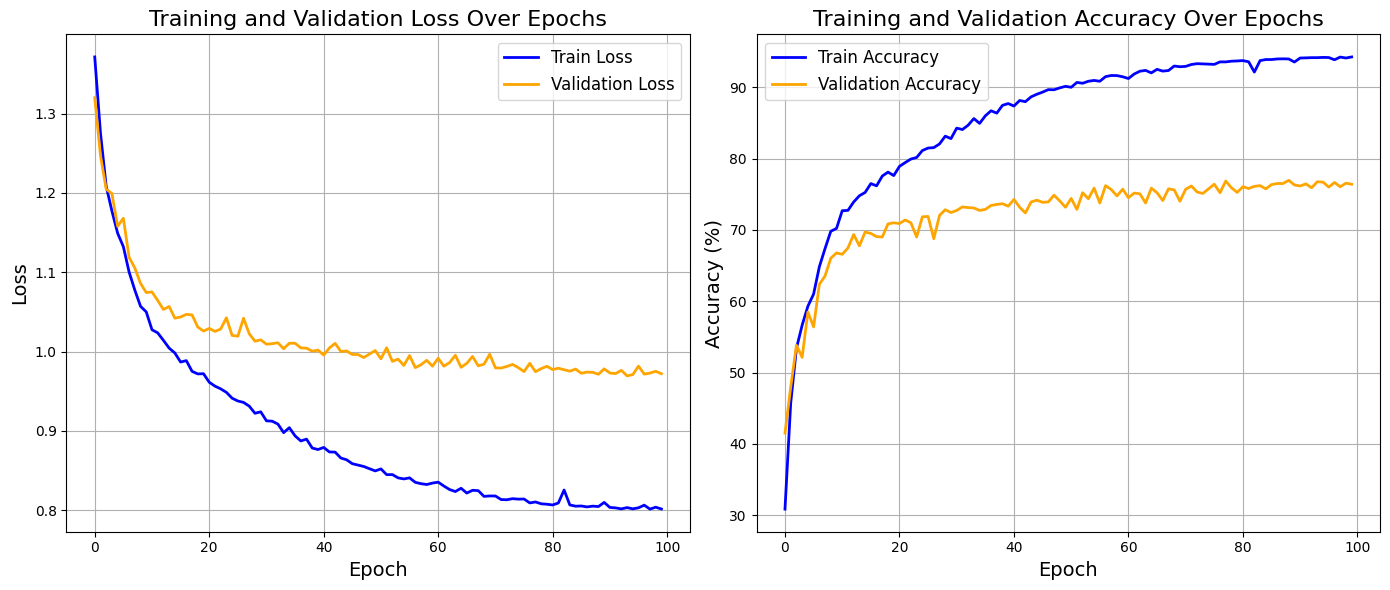

In [135]:
plot_performance(train_losses, val_losses, train_accs, val_accs)

## Test the model

In [137]:
test_model(model1,test_dataset,32,False)

Test Accuracy = 0.7800, F1 Score = 0.7796


# Model 3 

In [138]:
class CNNModel3(nn.Module):
    def __init__(self):
        super(CNNModel3, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        # self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, padding=1)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, padding=1)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2, padding=1)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool4 = nn.MaxPool2d(2, padding=1)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(25600, 256) # 
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 64) #
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.conv1(x)
        # x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool4(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)

        x = self.drop2(x)
        x = self.fc3(x)
        
        return F.softmax(x, dim=1)

In [141]:
model3 = CNNModel3()
model3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.0001)

train_losses3, val_losses3, train_accs3, val_accs3 = train_model(model3,
                                                                train_dataset=train_dataset,
                                                                val_dataset=val_dataset,
                                                                criterion=criterion,
                                                                optimizer=optimizer,
                                                                epochs=100,
                                                                batch_size=32,
                                                                verbose=1)

Epoch 1/100, Train Loss: 1.3789, Train Accuracy: 27.45%, Validation Loss: 1.3338, Validation Accuracy: 35.05%
Epoch 2/100, Train Loss: 1.3136, Train Accuracy: 39.37%, Validation Loss: 1.2786, Validation Accuracy: 43.84%
Epoch 3/100, Train Loss: 1.2863, Train Accuracy: 43.26%, Validation Loss: 1.2648, Validation Accuracy: 45.23%
Epoch 4/100, Train Loss: 1.2712, Train Accuracy: 44.52%, Validation Loss: 1.2425, Validation Accuracy: 48.91%
Epoch 5/100, Train Loss: 1.2458, Train Accuracy: 48.59%, Validation Loss: 1.2102, Validation Accuracy: 51.64%
Epoch 6/100, Train Loss: 1.2093, Train Accuracy: 51.89%, Validation Loss: 1.1929, Validation Accuracy: 53.67%
Epoch 7/100, Train Loss: 1.1900, Train Accuracy: 54.52%, Validation Loss: 1.1762, Validation Accuracy: 56.75%
Epoch 8/100, Train Loss: 1.1505, Train Accuracy: 59.04%, Validation Loss: 1.1612, Validation Accuracy: 57.55%
Epoch 9/100, Train Loss: 1.1280, Train Accuracy: 61.49%, Validation Loss: 1.1230, Validation Accuracy: 60.77%
Epoch 10/1

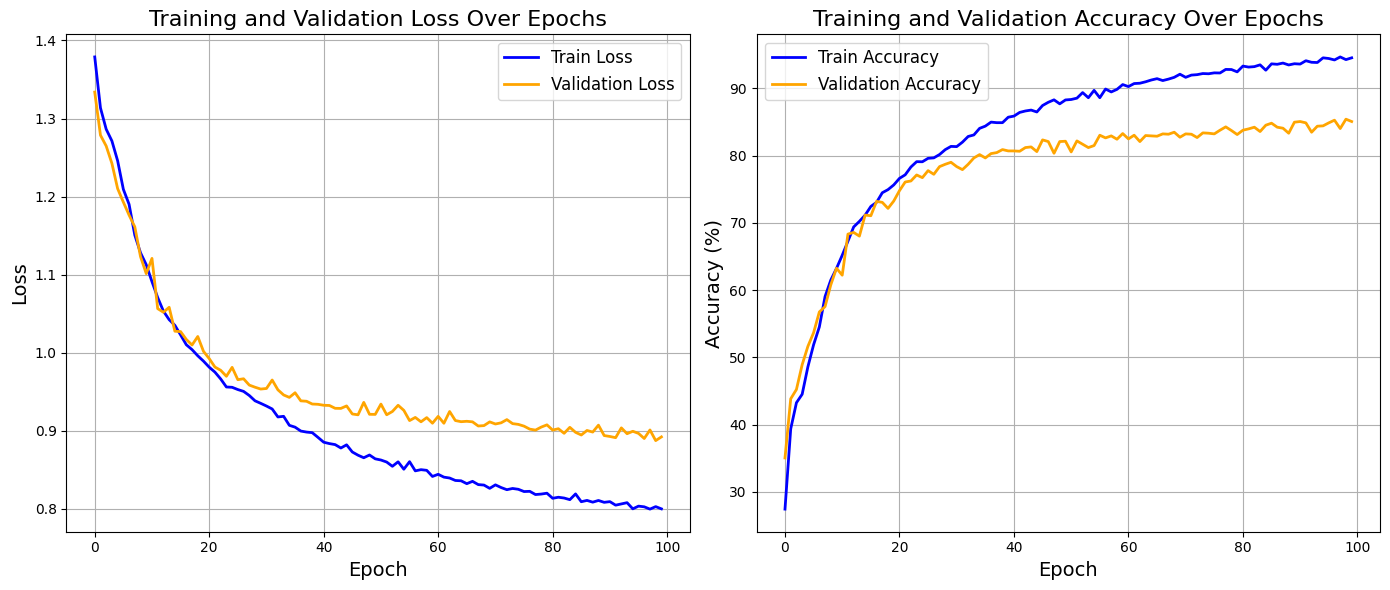

In [142]:
plot_performance(train_losses3, val_losses3, train_accs3, val_accs3)

In [144]:
test_model(model3,test_dataset,32,False)

Test Accuracy = 0.8605, F1 Score = 0.8605


# Model 5

In [151]:
class CNNModel5(nn.Module):
    def __init__(self):
        super(CNNModel5, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)
        self.sdrop = nn.Dropout2d(0.25)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)
        self.sdrop2 = nn.Dropout2d(0.25)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2)
        self.sdrop3 = nn.Dropout2d(0.25)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2)
        self.sdrop4 = nn.Dropout2d(0.25)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(25600, 256)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 64)
        self.drop2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.sdrop(self.pool1(F.relu(self.bn1(self.conv1(x)))))
        x = self.sdrop2(self.pool2(F.relu(self.bn2(self.conv2(x)))))
        x = self.sdrop3(self.pool3(F.relu(self.bn3(self.conv3(x)))))
        x = self.sdrop4(self.pool4(F.relu(self.bn4(self.conv4(x)))))

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        return F.softmax(self.fc3(x), dim=1)


In [152]:
model5 = CNNModel5()
model5.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=0.0001)
train_losses5, val_losses5, train_accs5, val_accs5 = train_model(model5,
                                        train_dataset=train_dataset,
                                        val_dataset=val_dataset,
                                        criterion=criterion,
                                        optimizer=optimizer,
                                        epochs=100,
                                        batch_size=32)

Epoch 1/100, Train Loss: 1.3840, Train Accuracy: 28.05%, Validation Loss: 1.3375, Validation Accuracy: 33.02%
Epoch 2/100, Train Loss: 1.3398, Train Accuracy: 35.89%, Validation Loss: 1.3059, Validation Accuracy: 41.56%
Epoch 3/100, Train Loss: 1.3051, Train Accuracy: 40.94%, Validation Loss: 1.2642, Validation Accuracy: 46.23%
Epoch 4/100, Train Loss: 1.2780, Train Accuracy: 43.66%, Validation Loss: 1.2523, Validation Accuracy: 45.28%
Epoch 5/100, Train Loss: 1.2368, Train Accuracy: 48.94%, Validation Loss: 1.2009, Validation Accuracy: 52.09%
Epoch 6/100, Train Loss: 1.1952, Train Accuracy: 53.63%, Validation Loss: 1.1512, Validation Accuracy: 58.59%
Epoch 7/100, Train Loss: 1.1552, Train Accuracy: 58.13%, Validation Loss: 1.0833, Validation Accuracy: 65.54%
Epoch 8/100, Train Loss: 1.1106, Train Accuracy: 63.34%, Validation Loss: 1.0387, Validation Accuracy: 70.41%
Epoch 9/100, Train Loss: 1.0816, Train Accuracy: 66.18%, Validation Loss: 1.0336, Validation Accuracy: 70.56%
Epoch 10/1

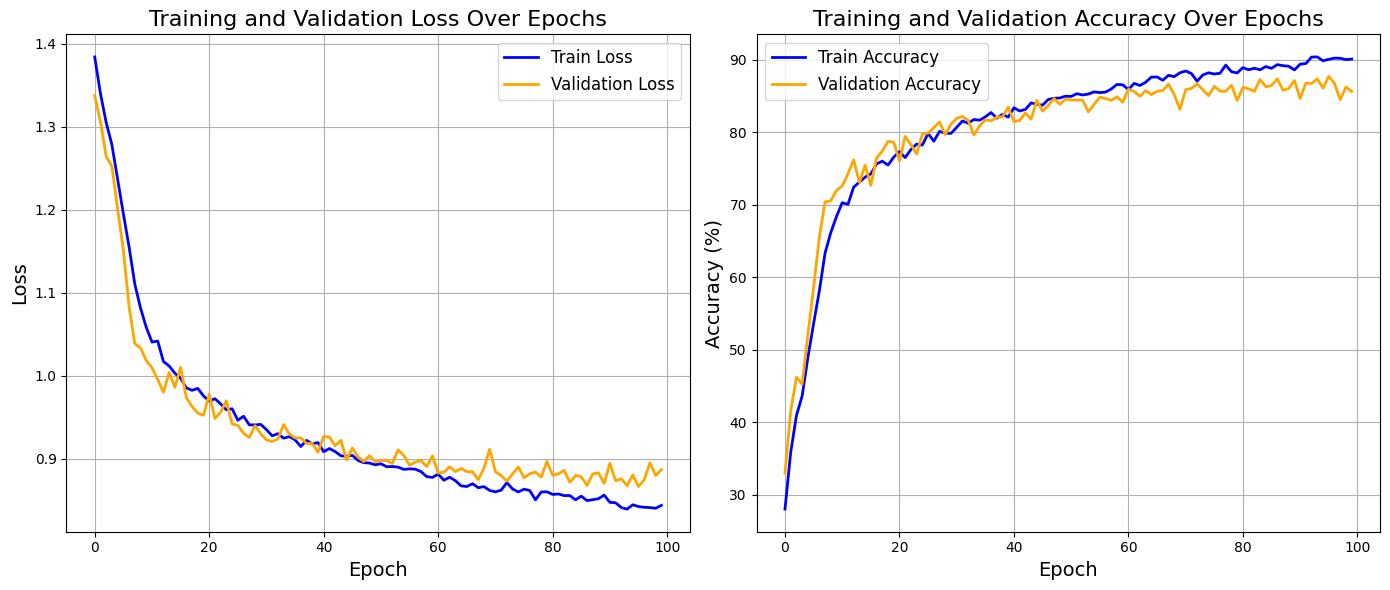

In [153]:
plot_performance(train_losses5, val_losses5, train_accs5, val_accs5)

In [154]:
test_model(model5,test_dataset,32,False)

Test Accuracy = 0.8635, F1 Score = 0.8635


### 5x2 Cross Validation

In [197]:
def cross_validate_5x2(model_class, criterion, optimizer_class, dataset, device, model_args=(), epochs=10):
    kf = KFold(n_splits=2, shuffle=True, random_state=42)  # Create 2-fold splitter
    # results = []

    for i in range(5):  # Repeat the 2-fold CV process 5 times
        print(f"5x2 CV Round {i + 1}")

        # fold_results = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            # print(f"Fold {fold + 1}")

            train_subset = torch.utils.data.Subset(dataset, train_idx)
            val_subset = torch.utils.data.Subset(dataset, val_idx)
            train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

            model = model_class(*model_args).to(device)
            optimizer = optimizer_class(model.parameters())

            # Training
            for epoch in range(epochs):
                model.train()
                for x_batch, y_batch in train_loader:
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    optimizer.zero_grad()
                    outputs = model(x_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()

            # Validation
            model.eval()
            val_predictions = []
            val_labels = []
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    outputs = model(x_val)
                    _, predicted = torch.max(outputs, 1)
                    val_predictions.extend(predicted.cpu().numpy())
                    val_labels.extend(y_val.cpu().numpy())

            # Metrics
            accuracy = accuracy_score(val_labels, val_predictions)
            f1 = f1_score(val_labels, val_predictions, average='weighted')
            # fold_results.append({'accuracy': accuracy, 'f1_score': f1})

            print(f"Fold {fold + 1}: Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}")

    #     results.append(fold_results)

    # avg_accuracy = np.mean([res['accuracy'] for round_result in results for res in round_result])
    # avg_f1 = np.mean([res['f1_score'] for round_result in results for res in round_result])

    # print(f"Average Accuracy: {avg_accuracy:.4f}")
    # print(f"Average F1 Score: {avg_f1:.4f}")

    # return results

In [ ]:
start_time = time.time()

cross_validate_5x2(
    model_class=CNNModel5,
    criterion=nn.CrossEntropyLoss(),
    optimizer_class=lambda params: torch.optim.Adam(params, lr=0.0001),
    dataset=all_data,
    device=device,
    epochs=100
)

minutes = (end_time - start_time) // 60
seconds = (end_time - start_time) % 60
print(f"Duration: {minutes}m {seconds}s")

### Different Seeds

In [233]:
# def initialize_weights(model):
#     for layer in model.modules():
#         if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
#             print("x")
#             nn.init.xavier_uniform_(layer.weight)
#             if layer.bias is not None:
#                 print("y")
#                 nn.init.zeros_(layer.bias)
#         elif isinstance(layer, nn.LSTM):
#             for name, param in layer.named_parameters():
#                 if 'weight_ih' in name:
#                     print("a")
#                     nn.init.xavier_uniform_(param)
#                 elif 'weight_hh' in name:
#                     print("b")
#                     # nn.init.orthogonal_(param)
#                     nn.init.xavier_uniform_(param)
#                 elif 'bias' in name:
#                     print("c")
#                     nn.init.zeros_(param)

def initialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.LSTM):
            for name, param in layer.named_parameters():
                if 'weight_ih' in name:
                    # nn.init.xavier_uniform_(param)
                    nn.init.orthogonal_(param)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)
                    # Forget gate bias'ını artır
                    n = param.size(0)
                    param[n // 4:n // 2].data.fill_(1.0)


def evaluate_with_different_seeds(model_class, train_data, val_data, test_data, criterion, optimizer_class, device, model_args=(),epochs=100, seeds=[42, 123, 456, 789, 1011]):
    results = []

    for seed in seeds:
        print(f"Training with Seed {seed}")
        torch.manual_seed(seed)  # Set random seed
        np.random.seed(seed)
        
        # Model initialization
        model = model_class(*model_args).to(device)
        initialize_weights(model)  # Initialize weights with custom function
        
        optimizer = optimizer_class(model.parameters())
        # train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
        
        _, _, _, _ = train_model(model, train_data, val_data, criterion, optimizer, epochs,verbose=0)
        test_model(model,test_data,32,show_detail=False)
        print("---")

In [ ]:
evaluate_with_different_seeds(
    model_class=CNNModel5,
    criterion=nn.CrossEntropyLoss(),
    optimizer_class=lambda params: torch.optim.Adam(params, lr=0.0001),
    device=device,
    epochs=100,
    seeds=[42, 123, 456, 789, 1011]
)

In [ ]:
best_seed = 456
torch.manual_seed(best_seed)
np.random.seed(best_seed)

### Different Optimizers

In [251]:
def evaluate_with_different_optimizers(model_class, train_data, val_data, test_data, criterion, optimizer_classes, model_args=(),device=device, epochs=30):
    for optimizer_class in optimizer_classes:
        model = model_class(*model_args).to(device)
        # initialize_weights(model)  # Initialize weights with custom function
        
        optimizer = optimizer_class(model.parameters())
        print(f"Training with {optimizer.__class__.__name__} optimizer...")
        a,b,c,d = train_model(model, train_data, val_data,criterion, optimizer, epochs,verbose=1)
        plot_performance(a,b,c,d)
        test_model(model,test_data,32,show_detail=False)
        print("---")

# ADAM optimizer was already tested
optimizers = [lambda params: torch.optim.SGD(params, lr=0.001),
              lambda params: torch.optim.RMSprop(params, lr=0.001, alpha=0.7)]

In [ ]:
evaluate_with_different_optimizers(
    model_class=CNNModel5,
    criterion=nn.CrossEntropyLoss(),
    optimizer_classes=optimizers,
    device=device,
    epochs=30
)

### Different Learning Rates

In [294]:
def evaluate_with_different_lr(model_class, train_dataset, val_dataset, test_dataset, criterion, lr_list, model_args=(),device=device, epochs=100, seed=None):
    for lr in lr_list:
        model = model_class(*model_args).to(device)
        # initialize_weights(model)  # Initialize weights with custom function
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        print(f"Training with learning rate {lr}...")
        _, _, _, _ = train_model(model,
                                 train_dataset=train_dataset,
                                 val_dataset=val_dataset,
                                 criterion=criterion,
                                 optimizer=optimizer,
                                 epochs=epochs,
                                 batch_size=32,
                                 verbose=1)

        test_model(model,test_dataset,32,show_detail=False)
        print("---")
learning_rates = [0.01, 0.001, 0.0005, 0.0001, 0.00005]

In [157]:
evaluate_with_different_lr(
    model_class=CNNModel5,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    criterion=nn.CrossEntropyLoss(),
    lr_list=learning_rates,
    device=device,
    epochs=30
)

Training with learning rate 0.01...
Epoch 1/30, Train Loss: 1.4944, Train Accuracy: 24.80%, Validation Loss: 1.4940, Validation Accuracy: 24.98%
Epoch 2/30, Train Loss: 1.4939, Train Accuracy: 25.00%, Validation Loss: 1.4940, Validation Accuracy: 24.98%
Epoch 3/30, Train Loss: 1.4934, Train Accuracy: 25.03%, Validation Loss: 1.4940, Validation Accuracy: 24.98%
Epoch 4/30, Train Loss: 1.4940, Train Accuracy: 24.95%, Validation Loss: 1.4940, Validation Accuracy: 24.98%
Epoch 5/30, Train Loss: 1.4940, Train Accuracy: 24.97%, Validation Loss: 1.4940, Validation Accuracy: 24.98%
Epoch 6/30, Train Loss: 1.4942, Train Accuracy: 24.95%, Validation Loss: 1.4940, Validation Accuracy: 24.98%
Early stopping at epoch 6. No improvement in validation loss for 5 epochs.
Test Accuracy = 0.2498, F1 Score = 0.0998
---
Training with learning rate 0.001...
Epoch 1/30, Train Loss: 1.4915, Train Accuracy: 24.95%, Validation Loss: 1.4938, Validation Accuracy: 24.98%
Epoch 2/30, Train Loss: 1.4942, Train Accur

## Feature Representation 

In [85]:
features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

model5.conv1.register_forward_hook(get_features('conv1'))
model5.conv2.register_forward_hook(get_features('conv2'))
model5.conv3.register_forward_hook(get_features('conv3'))
model5.conv4.register_forward_hook(get_features('conv4'))

input_image = test_dataset[0][0].unsqueeze(0).to(device) 
output = model5(input_image)

conv1_features = features['conv1']
conv2_features = features['conv2']
conv3_features = features['conv3']
conv4_features = features['conv4']


print(f"Conv1 features shape: {conv1_features.shape}")
print(f"Conv2 features shape: {conv2_features.shape}")
print(f"Conv3 features shape: {conv3_features.shape}")
print(f"Conv4 features shape: {conv4_features.shape}")

Conv1 features shape: torch.Size([1, 16, 128, 407])
Conv2 features shape: torch.Size([1, 32, 64, 203])
Conv3 features shape: torch.Size([1, 64, 32, 101])
Conv4 features shape: torch.Size([1, 128, 16, 50])


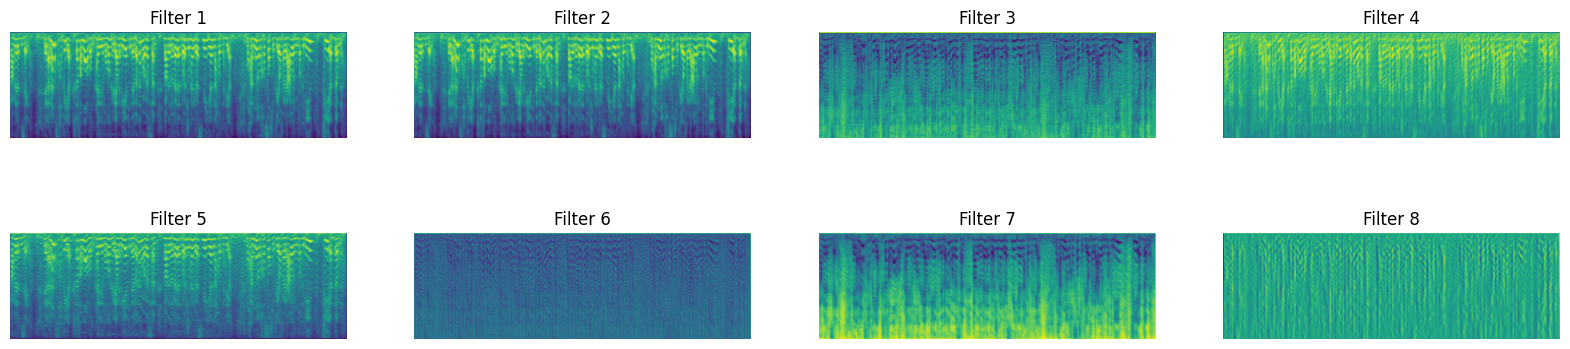

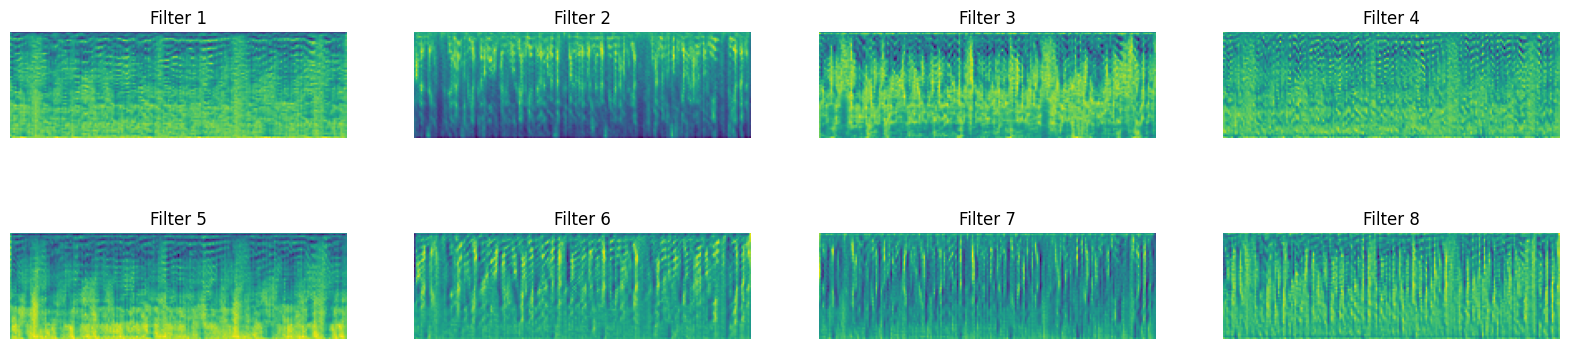

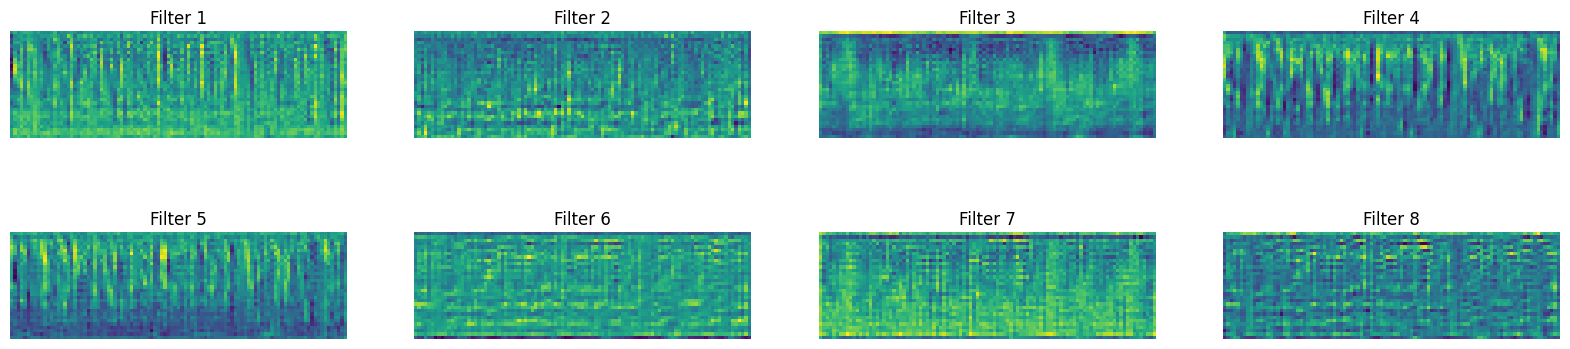

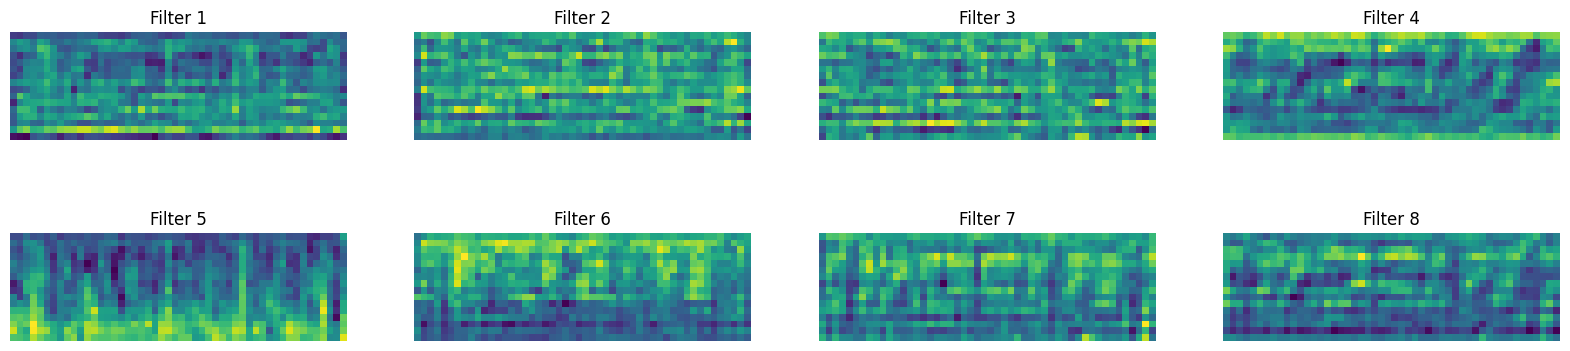

In [87]:
def visualize_feature_maps(features):
    n_filters = features.shape[1]
    plt.figure(figsize=(20, 10))

    for i in range(min(n_filters, 8)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(features[0, i].cpu().numpy(), cmap='viridis')
        plt.axis('off')
        plt.title(f"Filter {i + 1}")
    plt.show()

visualize_feature_maps(conv1_features)
visualize_feature_maps(conv2_features)
visualize_feature_maps(conv3_features)
visualize_feature_maps(conv4_features)

## Ablation Study

### Train with one fourth of the data

In [94]:
total_subset_size = len(Y_train) // 4  # 1/4 of original train dataset

num_labels = len(np.unique(Y_train))
subset_size_per_label = total_subset_size // num_labels

selected_indices = []
for label in np.unique(Y_train):
    label_indices = np.where(Y_train == label)[0]
    selected_indices.extend(
        np.random.choice(label_indices, subset_size_per_label, replace=False)
    )

np.random.shuffle(selected_indices)

X_subset = X_train[selected_indices]
Y_subset = Y_train[selected_indices]

train_subset = CustomDataset(X_subset, Y_subset)

Shape: torch.Size([1508, 1, 128, 407])


In [ ]:
model5_abl1 = CNNModel5()
model5_abl1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5_abl1.parameters(), lr=0.0001)
train_losses5, val_losses5 = train_model(model5_abl1, criterion, optimizer, 100, train_dataset=train_subset)

Epoch 1/100, Train Loss: 1.3955, Train Accuracy: 26.53%, Validation Loss: 1.3799, Validation Accuracy: 26.61%
Epoch 2/100, Train Loss: 1.3921, Train Accuracy: 27.72%, Validation Loss: 1.3690, Validation Accuracy: 28.90%
Epoch 3/100, Train Loss: 1.3821, Train Accuracy: 28.25%, Validation Loss: 1.3565, Validation Accuracy: 32.27%
Epoch 4/100, Train Loss: 1.3620, Train Accuracy: 32.03%, Validation Loss: 1.3726, Validation Accuracy: 29.84%
Epoch 5/100, Train Loss: 1.3615, Train Accuracy: 32.36%, Validation Loss: 1.3675, Validation Accuracy: 30.93%
Epoch 6/100, Train Loss: 1.3465, Train Accuracy: 35.15%, Validation Loss: 1.3584, Validation Accuracy: 31.83%
Epoch 7/100, Train Loss: 1.3493, Train Accuracy: 34.48%, Validation Loss: 1.3504, Validation Accuracy: 32.92%
Epoch 8/100, Train Loss: 1.3348, Train Accuracy: 36.34%, Validation Loss: 1.3464, Validation Accuracy: 34.36%
Epoch 9/100, Train Loss: 1.3196, Train Accuracy: 39.32%, Validation Loss: 1.3168, Validation Accuracy: 38.33%
Epoch 10/1

In [96]:
test_model(model5_abl1,32,False)

Test Accuracy = 0.7815, F1 Score = 0.7810


### Remove the last Convolution layer

In [99]:
class CNNModel6(nn.Module):
    def __init__(self):
        super(CNNModel6, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)
        self.sdrop = nn.Dropout2d(0.25)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)
        self.sdrop2 = nn.Dropout2d(0.25)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2)
        self.sdrop3 = nn.Dropout2d(0.25)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(51200, 256)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 64)
        self.drop2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.sdrop(self.pool1(F.relu(self.bn1(self.conv1(x)))))
        x = self.sdrop2(self.pool2(F.relu(self.bn2(self.conv2(x)))))
        x = self.sdrop3(self.pool3(F.relu(self.bn3(self.conv3(x)))))

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        return F.softmax(self.fc3(x), dim=1)


In [100]:
model6 = CNNModel6()
model6.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model6.parameters(), lr=0.0001)
train_losses6, val_losses6 = train_model(model6, criterion, optimizer, 100)

Epoch 1/100, Train Loss: 1.3830, Train Accuracy: 29.44%, Validation Loss: 1.3174, Validation Accuracy: 39.37%
Epoch 2/100, Train Loss: 1.3252, Train Accuracy: 37.33%, Validation Loss: 1.2972, Validation Accuracy: 40.37%
Epoch 3/100, Train Loss: 1.2907, Train Accuracy: 42.68%, Validation Loss: 1.2341, Validation Accuracy: 51.44%
Epoch 4/100, Train Loss: 1.2628, Train Accuracy: 46.13%, Validation Loss: 1.2287, Validation Accuracy: 48.76%
Epoch 5/100, Train Loss: 1.2311, Train Accuracy: 49.83%, Validation Loss: 1.1859, Validation Accuracy: 56.01%
Epoch 6/100, Train Loss: 1.2010, Train Accuracy: 53.26%, Validation Loss: 1.1455, Validation Accuracy: 59.24%
Epoch 7/100, Train Loss: 1.1650, Train Accuracy: 57.81%, Validation Loss: 1.1348, Validation Accuracy: 60.63%
Epoch 8/100, Train Loss: 1.1336, Train Accuracy: 61.16%, Validation Loss: 1.0888, Validation Accuracy: 64.85%
Epoch 9/100, Train Loss: 1.0948, Train Accuracy: 64.77%, Validation Loss: 1.0523, Validation Accuracy: 68.97%
Epoch 10/1

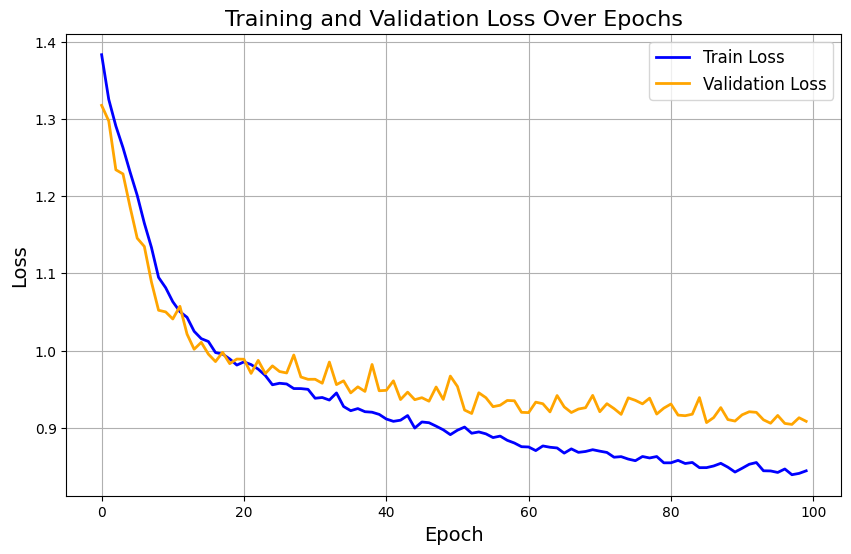

In [101]:
plot_loss(train_losses6, val_losses6)

In [102]:
test_model(model6, 32, False)

Test Accuracy = 0.8347, F1 Score = 0.8339


### Remove the last 2 fully connected layers

In [10]:
class CNN_ablation3(nn.Module):
    def __init__(self):
        super(CNN_ablation3, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)
        self.sdrop = nn.Dropout2d(0.25)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)
        self.sdrop2 = nn.Dropout2d(0.25)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2)
        self.sdrop3 = nn.Dropout2d(0.25)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2)
        self.sdrop4 = nn.Dropout2d(0.25)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(25600, 4)

    def forward(self, x):
        x = self.sdrop(self.pool1(F.relu(self.bn1(self.conv1(x)))))
        x = self.sdrop2(self.pool2(F.relu(self.bn2(self.conv2(x)))))
        x = self.sdrop3(self.pool3(F.relu(self.bn3(self.conv3(x)))))
        x = self.sdrop4(self.pool4(F.relu(self.bn4(self.conv4(x)))))

        x = self.flatten(x)
        
        return F.softmax(self.fc1(x), dim=1)


In [11]:
model_a3 = CNN_ablation3()
model_a3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_a3.parameters(), lr=0.0001)
train_losses_a3, val_losses_a3 = train_model(model_a3, criterion, optimizer, 100)

Epoch 1/100, Train Loss: 1.3784, Train Accuracy: 31.56%, Validation Loss: 1.3912, Validation Accuracy: 30.98%
Epoch 2/100, Train Loss: 1.3144, Train Accuracy: 40.22%, Validation Loss: 1.2808, Validation Accuracy: 42.75%
Epoch 3/100, Train Loss: 1.2552, Train Accuracy: 46.36%, Validation Loss: 1.2306, Validation Accuracy: 48.61%
Epoch 4/100, Train Loss: 1.2161, Train Accuracy: 51.04%, Validation Loss: 1.2346, Validation Accuracy: 48.71%
Epoch 5/100, Train Loss: 1.1912, Train Accuracy: 53.96%, Validation Loss: 1.1741, Validation Accuracy: 55.36%
Epoch 6/100, Train Loss: 1.1373, Train Accuracy: 59.60%, Validation Loss: 1.1526, Validation Accuracy: 57.70%
Epoch 7/100, Train Loss: 1.1011, Train Accuracy: 63.48%, Validation Loss: 1.0974, Validation Accuracy: 64.25%
Epoch 8/100, Train Loss: 1.0744, Train Accuracy: 66.84%, Validation Loss: 1.0817, Validation Accuracy: 65.34%
Epoch 9/100, Train Loss: 1.0503, Train Accuracy: 68.99%, Validation Loss: 1.0610, Validation Accuracy: 66.83%
Epoch 10/1

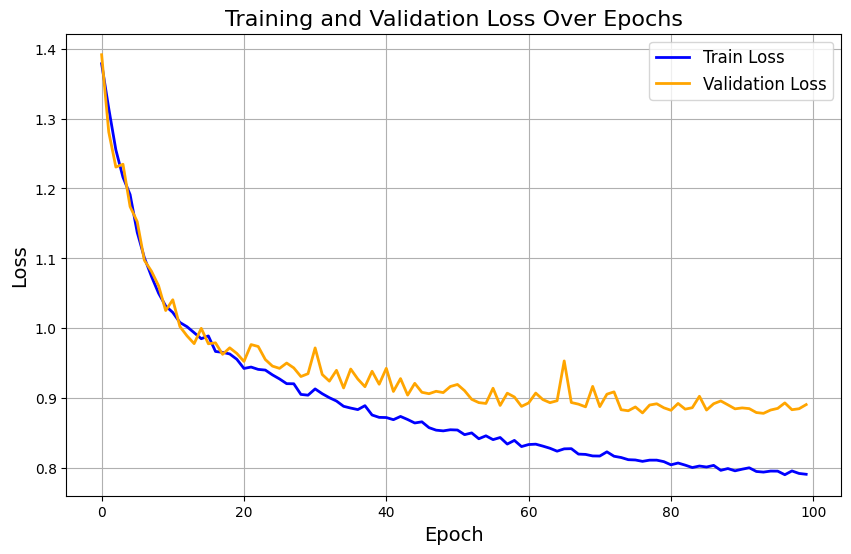

In [ ]:
plot_loss(train_losses_a3, val_losses_a3)

In [12]:
test_model(model_a3, 32, False)

Test Accuracy = 0.8615, F1 Score = 0.8604


# RNN

In [190]:
class RNNDataset(Dataset):
    def __init__(self, X_data, Y_data):
        X_data = np.transpose(X_data, (0, 2, 1))
        self.X = torch.from_numpy(X_data)
        self.Y = torch.from_numpy(Y_data)
        print("Shape:", self.X.shape)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sample = self.X[idx], self.Y[idx]
        return sample

train_data_rnn = RNNDataset(X_train, Y_train)
val_data_rnn = RNNDataset(X_val, Y_val)
test_data_rnn = RNNDataset(X_test, Y_test)
all_data_rnn = RNNDataset(X, Y)

Shape: torch.Size([6040, 407, 128])
Shape: torch.Size([2014, 407, 128])
Shape: torch.Size([2014, 407, 128])
Shape: torch.Size([10068, 407, 128])


# LSTM 1

In [290]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers):
        super(LSTMClassifier, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        # x: (batch_size, time_steps, input_dim)
        _, (h_n, _) = self.lstm(x)  # h_n: (num_layers, batch_size, hidden_dim)
        
        out = self.fc(h_n[-1])  # h_n[-1]: (batch_size, hidden_dim)
        return out

In [ ]:
# Hyperparameters
input_dim = 128      
time_steps = 407   
hidden_dim = 64   
num_classes = 4  
num_layers = 1  
learning_rate = 0.001
batch_size = 32 
epochs = 100


# Model
model_lstm = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, num_layers=num_layers)
model_lstm.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=learning_rate, weight_decay=1e-4)

train_losses_rnn, val_losses_rnn, train_accs_rnn, val_accs_rnn = train_model(model_lstm,
                                                                             train_dataset=train_data_rnn,
                                                                             val_dataset=val_data_rnn, 
                                                                             criterion=criterion, 
                                                                             optimizer=optimizer, 
                                                                             epochs=epochs, 
                                                                             batch_size=batch_size,
                                                                             verbose=1)


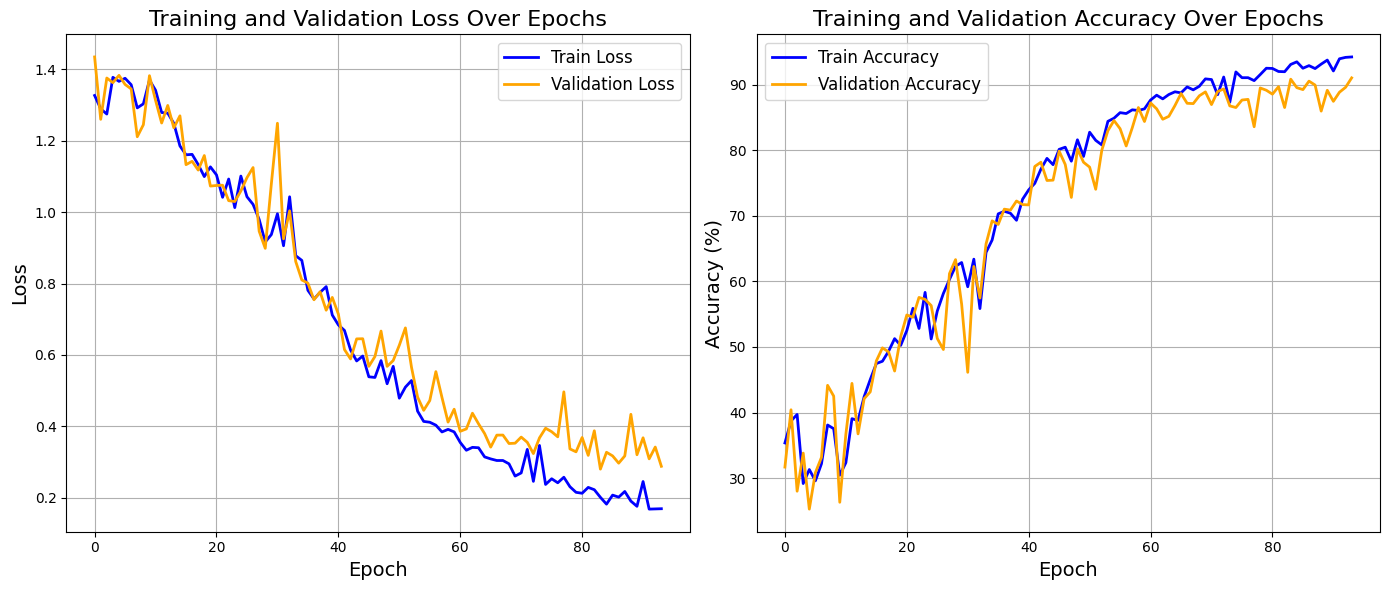

In [280]:
plot_performance(train_losses_rnn, val_losses_rnn, train_accs_rnn, val_accs_rnn)

In [281]:
test_model(model_lstm, test_data_rnn, 32, False)

Test Accuracy = 0.9062, F1 Score = 0.9063


## LSTM 2 

In [262]:
class LSTMClassifier2(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers):
        super(LSTMClassifier2, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, num_classes)
    
    def forward(self, x):
        hidden_states = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        cell_states = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x,(hidden_states, cell_states))
        out = F.relu(self.fc(out[:,-1,:]))
        out = self.fc2(out)

        return out

        
        # # x: (batch_size, time_steps, input_dim)
        # _, (h_n, _) = self.lstm(x)  # h_n: (num_layers, batch_size, hidden_dim)
        
        # # Fully Connected
        # out = self.fc(h_n[-1])  # h_n[-1]: (batch_size, hidden_dim)
        # return out

In [263]:
# Hyperparametreler
input_dim = 128       # Frekans boyutu
time_steps = 407      # Zaman adımı boyutu
hidden_dim = 64       # LSTM gizli katman boyutu
num_classes = 4       # Çıkış sınıf sayısı
num_layers = 1        # LSTM katman sayısı
learning_rate = 0.001
batch_size = 32       # Örnek batch boyutu
epochs = 100           # Eğitim dönemi sayısı


# Model oluşturma
model_lstm2 = LSTMClassifier2(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, num_layers=num_layers)
model_lstm2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm2.parameters(), lr=learning_rate, weight_decay=1e-4)

train_losses_rnn2, val_losses_rnn2, train_accs_rnn2, val_accs_rnn2 = train_model(model_lstm2,
                                                                             train_dataset=train_data_rnn,
                                                                             val_dataset=val_data_rnn, 
                                                                             criterion=criterion, 
                                                                             optimizer=optimizer, 
                                                                             epochs=epochs, 
                                                                             batch_size=batch_size,
                                                                             verbose=1)


Epoch 1/100, Train Loss: 1.3658, Train Accuracy: 31.84%, Validation Loss: 1.3257, Validation Accuracy: 36.84%
Epoch 2/100, Train Loss: 1.3074, Train Accuracy: 37.60%, Validation Loss: 1.2554, Validation Accuracy: 41.86%
Epoch 3/100, Train Loss: 1.2733, Train Accuracy: 39.98%, Validation Loss: 1.3712, Validation Accuracy: 30.98%
Epoch 4/100, Train Loss: 1.3191, Train Accuracy: 38.34%, Validation Loss: 1.3259, Validation Accuracy: 42.60%
Epoch 5/100, Train Loss: 1.2294, Train Accuracy: 45.08%, Validation Loss: 1.2031, Validation Accuracy: 47.32%
Epoch 6/100, Train Loss: 1.1434, Train Accuracy: 48.41%, Validation Loss: 1.0988, Validation Accuracy: 52.38%
Epoch 7/100, Train Loss: 1.0746, Train Accuracy: 52.76%, Validation Loss: 1.0376, Validation Accuracy: 54.67%
Epoch 8/100, Train Loss: 1.0053, Train Accuracy: 56.99%, Validation Loss: 1.0298, Validation Accuracy: 56.06%
Epoch 9/100, Train Loss: 0.9367, Train Accuracy: 61.09%, Validation Loss: 0.9240, Validation Accuracy: 63.01%
Epoch 10/1

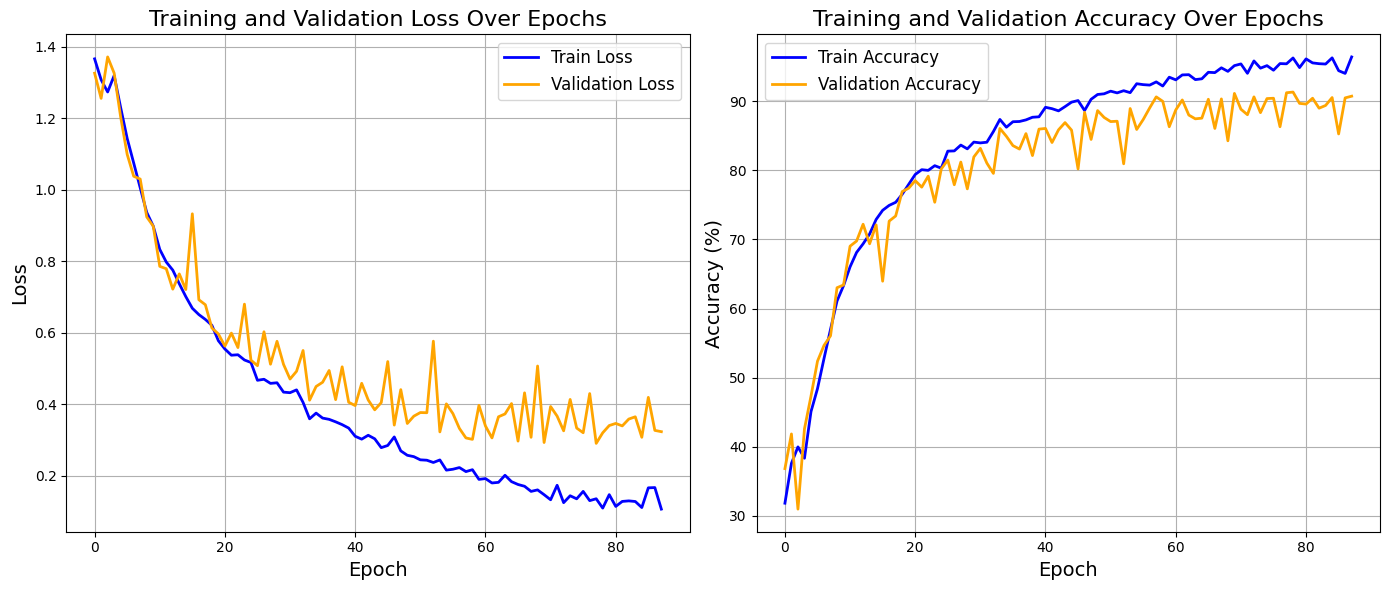

In [264]:
plot_performance(train_losses_rnn2, val_losses_rnn2, train_accs_rnn2, val_accs_rnn2)

In [265]:
test_model(model_lstm2, test_data_rnn, 32, False)

Test Accuracy = 0.9081, F1 Score = 0.9081


### 5x2 Cross Validation

In [211]:
model_args = input_dim, hidden_dim, num_classes, num_layers

criterion = nn.CrossEntropyLoss()
optimizer_class=lambda params: torch.optim.Adam(params, lr=0.0001)
optimizer = optim.Adam(model_lstm2.parameters(), lr=learning_rate, weight_decay=1e-4)
cross_validate_5x2(LSTMClassifier, criterion, optimizer_class, all_data_rnn, device, model_args, 30)

5x2 CV Round 1


KeyboardInterrupt: 

## Different Seeds

In [209]:
for layer in model_lstm.modules():
    for name, param in layer.named_parameters():
        print(name)

lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
fc.weight
fc.bias
weight_ih_l0
weight_hh_l0
bias_ih_l0
bias_hh_l0
weight
bias


In [234]:
evaluate_with_different_seeds(LSTMClassifier, train_data_rnn, val_data_rnn, test_data_rnn, criterion, optimizer_class, device, model_args, 100)

Training with Seed 42
Test Accuracy = 0.7562, F1 Score = 0.7563
---
Training with Seed 123
Test Accuracy = 0.8168, F1 Score = 0.8167
---
Training with Seed 456
Test Accuracy = 0.7746, F1 Score = 0.7754
---
Training with Seed 789


KeyboardInterrupt: 

## Different Optimizers

Training with SGD optimizer...
Epoch 1/100, Train Loss: 1.3860, Train Accuracy: 25.73%, Validation Loss: 1.3837, Validation Accuracy: 27.76%
Epoch 2/100, Train Loss: 1.3827, Train Accuracy: 28.91%, Validation Loss: 1.3815, Validation Accuracy: 31.23%
Epoch 3/100, Train Loss: 1.3800, Train Accuracy: 30.75%, Validation Loss: 1.3793, Validation Accuracy: 28.55%
Epoch 4/100, Train Loss: 1.3776, Train Accuracy: 31.06%, Validation Loss: 1.3767, Validation Accuracy: 34.16%
Epoch 5/100, Train Loss: 1.3748, Train Accuracy: 34.06%, Validation Loss: 1.3741, Validation Accuracy: 33.86%
Epoch 6/100, Train Loss: 1.3716, Train Accuracy: 33.74%, Validation Loss: 1.3712, Validation Accuracy: 35.60%
Epoch 7/100, Train Loss: 1.3682, Train Accuracy: 35.51%, Validation Loss: 1.3679, Validation Accuracy: 35.55%
Epoch 8/100, Train Loss: 1.3644, Train Accuracy: 35.45%, Validation Loss: 1.3636, Validation Accuracy: 35.65%
Epoch 9/100, Train Loss: 1.3593, Train Accuracy: 35.70%, Validation Loss: 1.3585, Validat

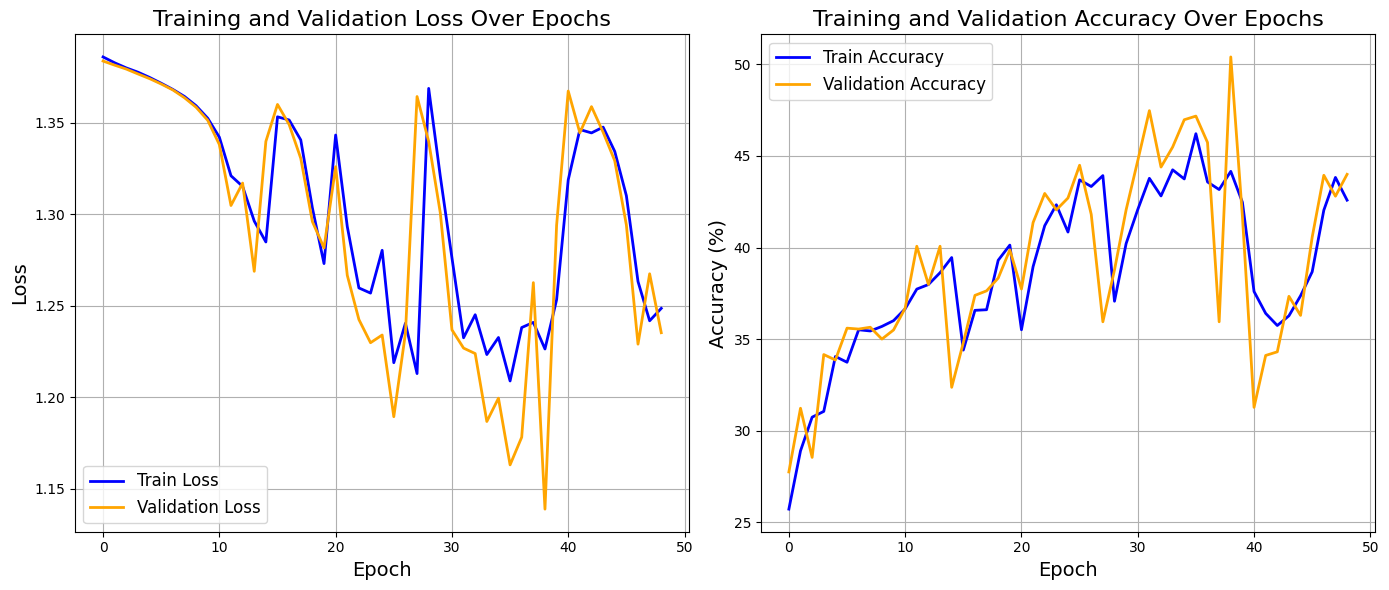

Test Accuracy = 0.4454, F1 Score = 0.4212
---
Training with RMSprop optimizer...
Epoch 1/100, Train Loss: 1.3333, Train Accuracy: 34.74%, Validation Loss: 1.2952, Validation Accuracy: 38.53%
Epoch 2/100, Train Loss: 1.2673, Train Accuracy: 40.86%, Validation Loss: 1.2332, Validation Accuracy: 44.29%
Epoch 3/100, Train Loss: 1.2912, Train Accuracy: 39.21%, Validation Loss: 1.2243, Validation Accuracy: 43.94%
Epoch 4/100, Train Loss: 1.2257, Train Accuracy: 44.16%, Validation Loss: 1.1764, Validation Accuracy: 48.46%
Epoch 5/100, Train Loss: 1.2236, Train Accuracy: 44.69%, Validation Loss: 1.1866, Validation Accuracy: 47.37%
Epoch 6/100, Train Loss: 1.1865, Train Accuracy: 46.74%, Validation Loss: 1.1580, Validation Accuracy: 48.26%
Epoch 7/100, Train Loss: 1.1786, Train Accuracy: 47.24%, Validation Loss: 1.1678, Validation Accuracy: 47.52%
Epoch 8/100, Train Loss: 1.1777, Train Accuracy: 47.05%, Validation Loss: 1.1852, Validation Accuracy: 47.96%
Epoch 9/100, Train Loss: 1.1602, Train 

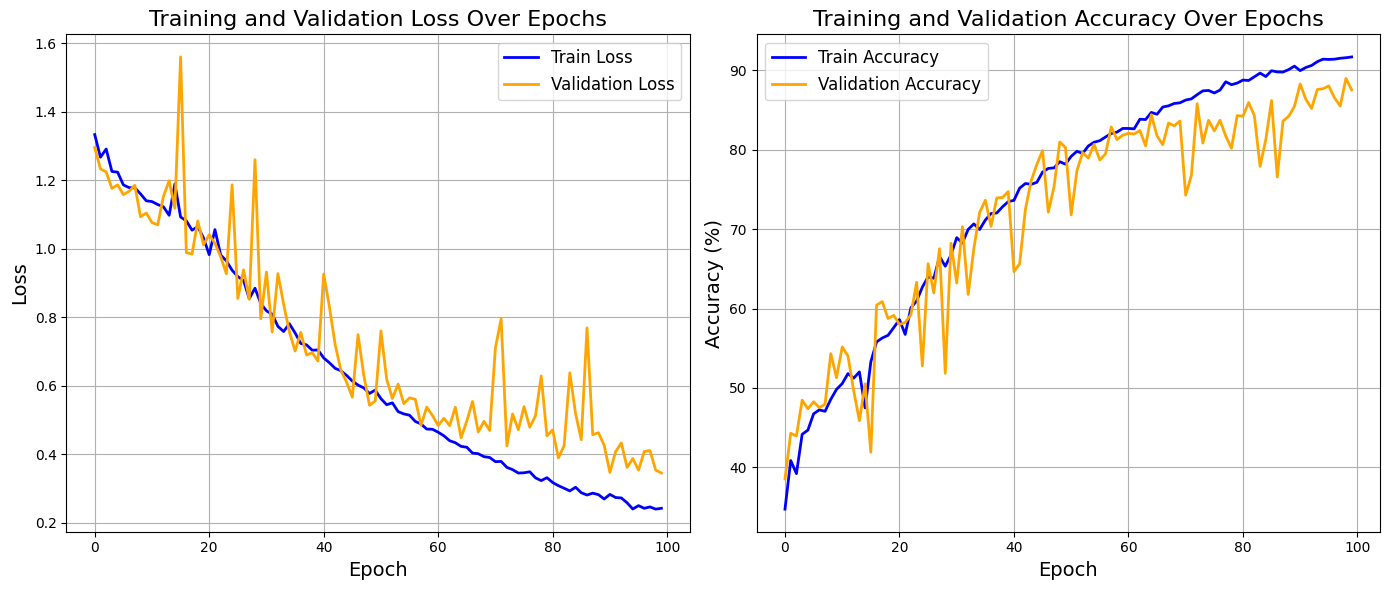

Test Accuracy = 0.8863, F1 Score = 0.8864
---


In [255]:
optimizers = [lambda params: torch.optim.SGD(params, lr=0.01),
              lambda params: torch.optim.RMSprop(params, lr=0.0005, alpha=0.9)]

evaluate_with_different_optimizers(LSTMClassifier,
                                   train_data_rnn,
                                   val_data_rnn,
                                   test_data_rnn,
                                   criterion=nn.CrossEntropyLoss(),
                                   optimizer_classes=optimizers,
                                   model_args=model_args,
                                   device=device,
                                   epochs=100)

## Different Learning Rates

In [295]:
model_args = input_dim, hidden_dim, num_classes, num_layers
learning_rates = [0.1, 0.01, 0.005, 0.001, 0.00005]
evaluate_with_different_lr(
    model_class=LSTMClassifier,
    train_dataset=train_data_rnn,
    val_dataset=val_data_rnn,
    test_dataset=test_data_rnn,
    criterion=nn.CrossEntropyLoss(),
    lr_list=learning_rates,
    model_args=model_args,
    device=device,
    epochs=100
    )

Training with learning rate 0.1...
Epoch 1/100, Train Loss: 1.5158, Train Accuracy: 25.45%, Validation Loss: 1.4162, Validation Accuracy: 25.27%
Epoch 2/100, Train Loss: 1.4743, Train Accuracy: 25.98%, Validation Loss: 1.4028, Validation Accuracy: 25.87%
Epoch 3/100, Train Loss: 1.4582, Train Accuracy: 26.36%, Validation Loss: 1.4411, Validation Accuracy: 26.42%
Epoch 4/100, Train Loss: 1.4538, Train Accuracy: 26.08%, Validation Loss: 1.3883, Validation Accuracy: 25.72%
Epoch 5/100, Train Loss: 1.4853, Train Accuracy: 25.78%, Validation Loss: 1.4377, Validation Accuracy: 26.27%
Epoch 6/100, Train Loss: 1.4353, Train Accuracy: 25.94%, Validation Loss: 1.4270, Validation Accuracy: 25.27%
Epoch 7/100, Train Loss: 1.4321, Train Accuracy: 26.67%, Validation Loss: 1.4391, Validation Accuracy: 26.76%
Epoch 8/100, Train Loss: 1.4516, Train Accuracy: 26.66%, Validation Loss: 1.4061, Validation Accuracy: 26.22%
Epoch 9/100, Train Loss: 1.4415, Train Accuracy: 25.51%, Validation Loss: 1.4668, Val